In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.7


exoplanet version: 0.2.0


# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data 
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract). 

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(dirname + "astro.txt", format="csv", fill_values=[(".", '0')])

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping 
# the primary and secondary star
ind = (astro_dates.value > 1975.) & (astro_dates.value < 1999.73) \
    & (~astro_data_full["rho"].mask) & (~astro_data_full["PA"].mask)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = 'jd'
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float) # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi/180.
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float) 
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg) # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit. 

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


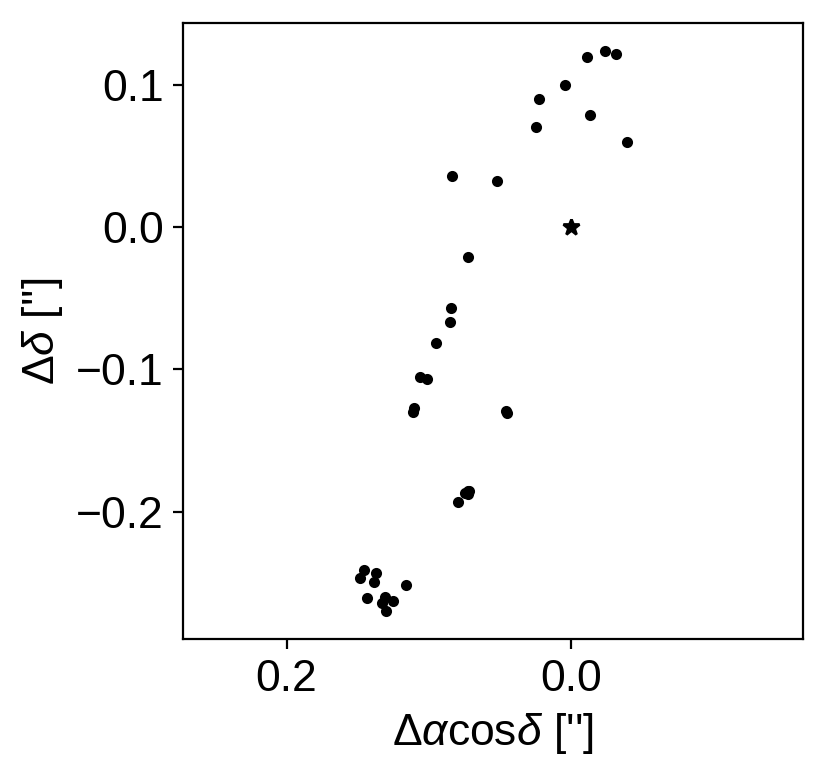

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0,0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

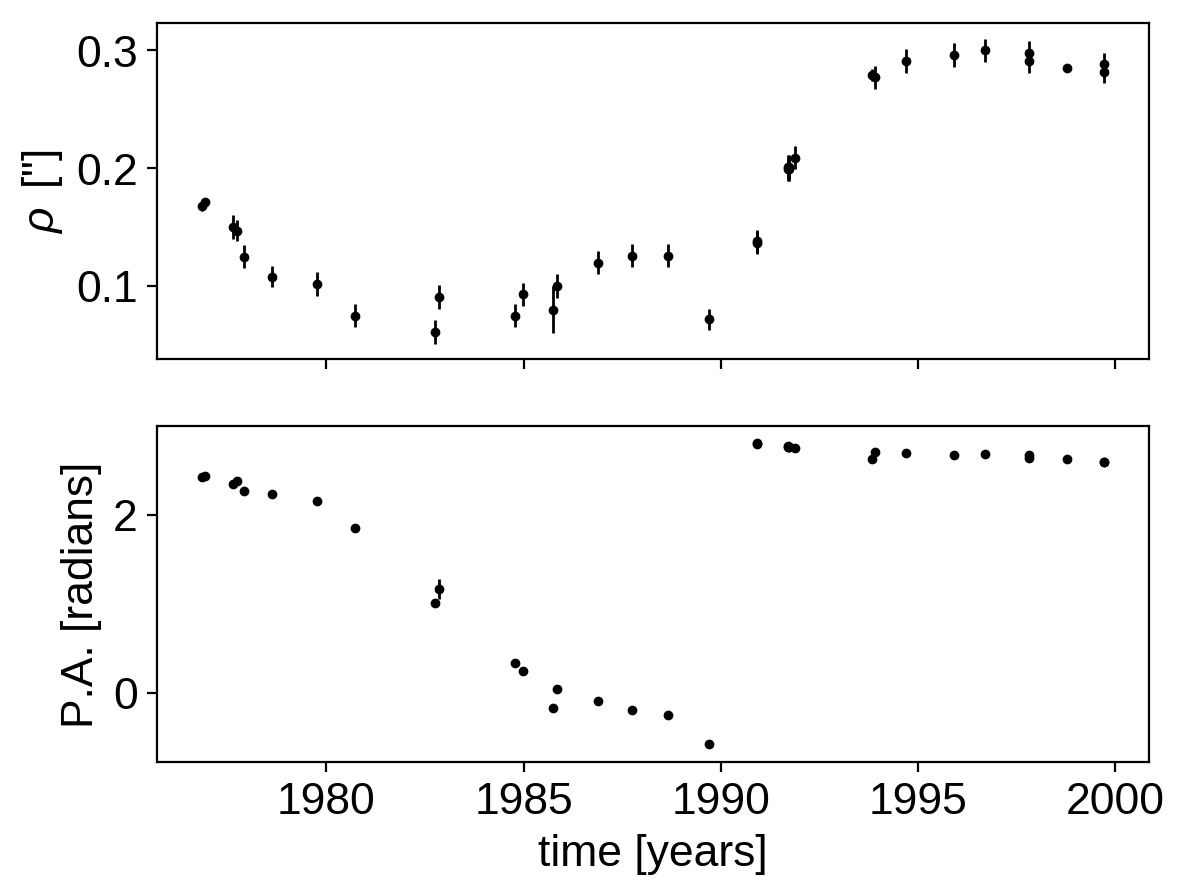

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [years]");

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

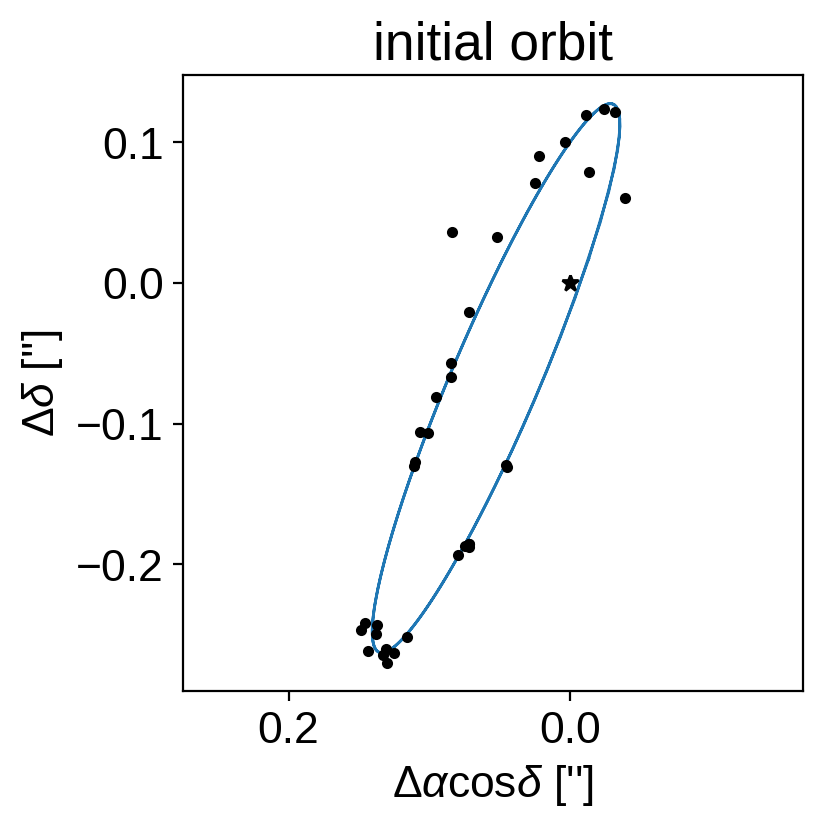

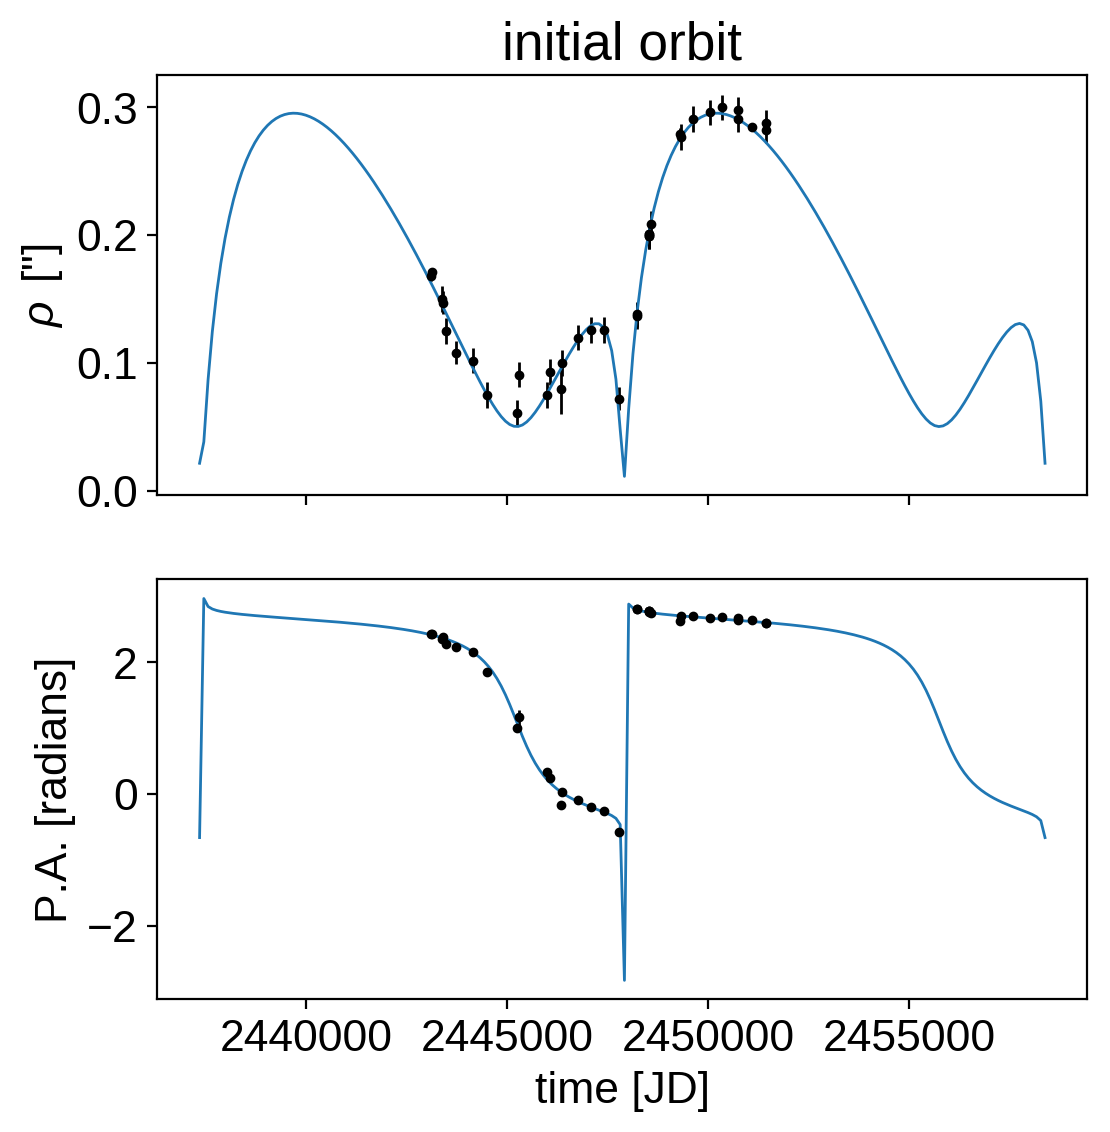

In [7]:
import pymc3 as pm 
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg 
P = 28.8 * 365.25 # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e,
    omega=omega, Omega=Omega)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200) # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit 
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta) # X is north
ys = rho * np.sin(theta) # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data) # X is north
ys = rho_data * np.sin(theta_data) # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit");

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit");

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r'P.A. [radians]')
ax[1].set_xlabel("time [JD]");

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)

def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec 
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)("m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0])
            plx = pm.Deterministic("plx", 1e-3 * m_plx)
            
        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years, 
        # so we'll set a broad prior on logP
        logP = pm.Normal("logP", mu=np.log(25*yr), sd=10.0, testval=np.log(28.8*yr))
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5*(Omega0 + omega0))
        m = Angle("m", testval=0.5*(Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2*np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform("cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg))
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun, t_periastron=tperi, period=P, 
            incl=incl, ecc=ecc, omega=omega, Omega=Omega)
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal("log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0)
        log_theta_s = pm.Normal("log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0)
        rho_tot_err = tt.sqrt(rho_err**2 + tt.exp(2*log_rho_s))
        theta_tot_err = tt.sqrt(theta_err**2 + tt.exp(2*log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to 
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data))
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting 
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)
    
    return model, map_soln

model, map_soln = get_model()

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 104.85554109314324 -> 147.14399186006233


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 147.14399186006233 -> 167.64220598198332


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 167.64220598198335 -> 210.06340668298847


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 210.06340668298847 -> 210.5013698914882


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__']


message: Optimization terminated successfully.
logp: 210.5013698914882 -> 215.02117742210876


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

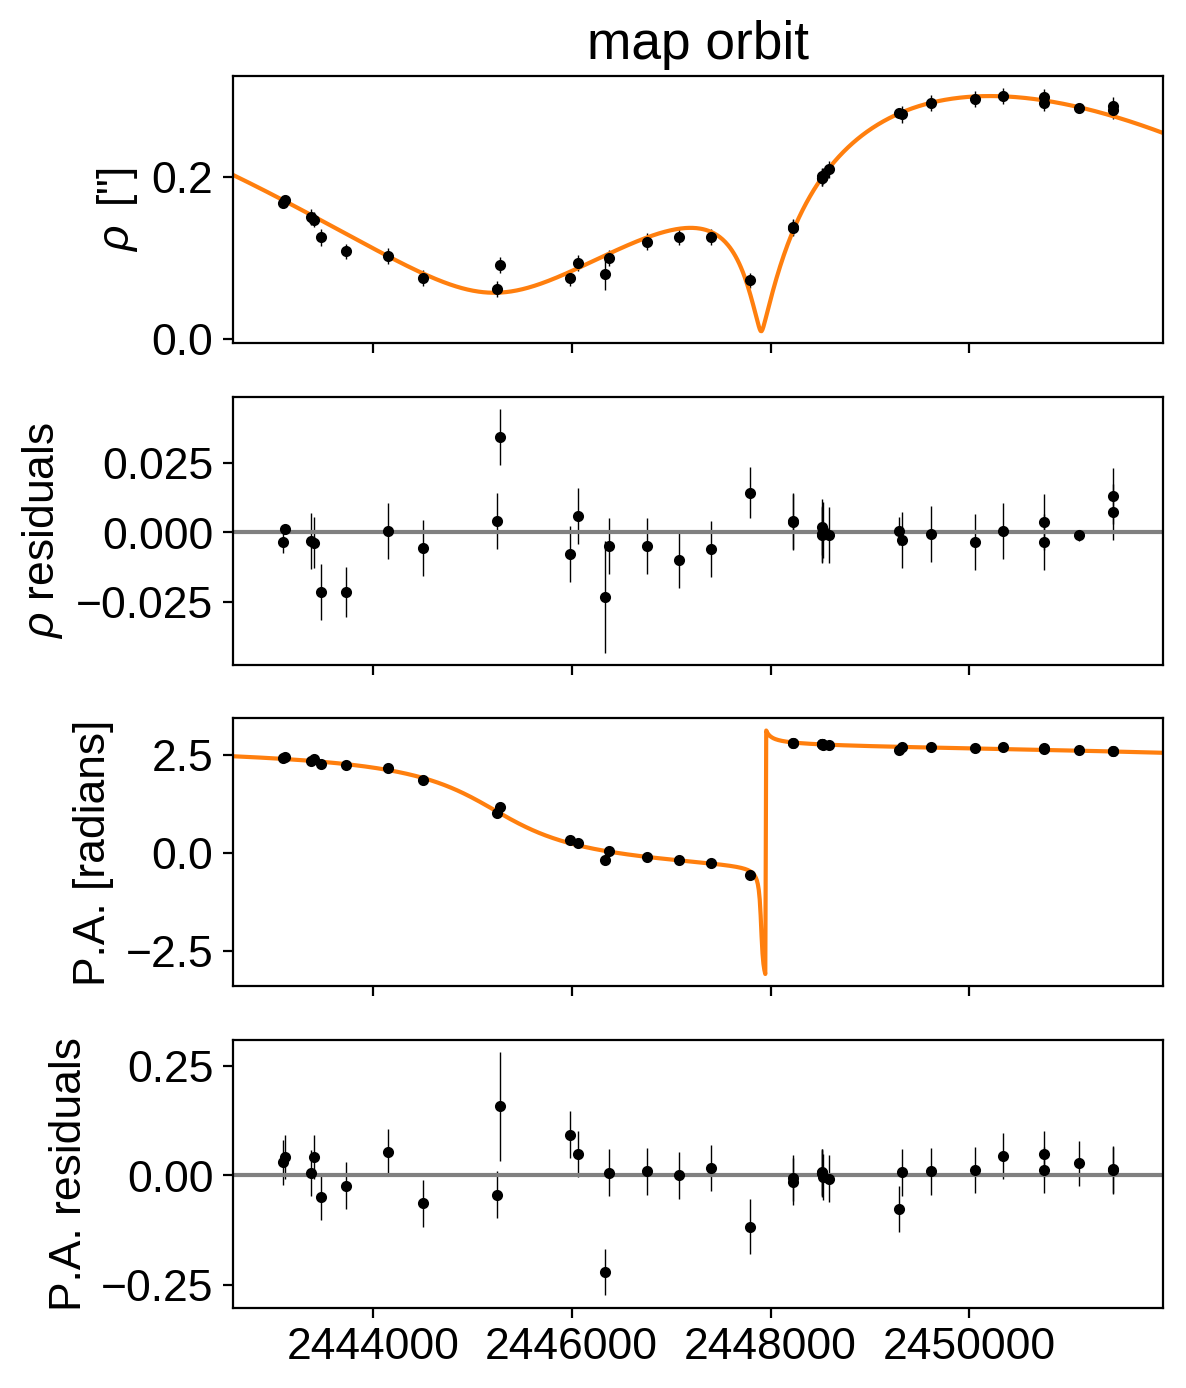

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6,8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'$\rho$ residuals')
ax[2].set_ylabel(r'P.A. [radians]')
ax[3].set_ylabel(r'P.A. residuals')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw) 

ax[3].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("map orbit");

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:05, 149.96draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:09, 85.71draws/s] 

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:10, 74.77draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:10, 74.64draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:00<00:11, 63.93draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:00<00:11, 65.65draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:00<00:12, 60.79draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:00<00:11, 62.81draws/s]

Sampling 4 chains:   9%|▉         | 72/808 [00:01<00:12, 60.95draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:01<00:10, 66.44draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:01<00:11, 65.11draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:01<00:10, 64.97draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:01<00:10, 66.22draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:01<00:10, 64.07draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:01<00:10, 64.54draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:01<00:11, 59.69draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:01<00:10, 64.37draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:02<00:11, 60.17draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:02<00:10, 63.04draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:02<00:10, 63.97draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:02<00:10, 59.48draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:02<00:10, 58.90draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:02<00:10, 60.27draws/s]

Sampling 4 chains:  23%|██▎       | 183/808 [00:02<00:10, 58.78draws/s]

Sampling 4 chains:  24%|██▎       | 190/808 [00:02<00:10, 60.77draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:03<00:09, 64.82draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:03<00:08, 69.57draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:03<00:09, 65.63draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:03<00:09, 63.43draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:03<00:09, 63.68draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:03<00:08, 65.01draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:03<00:08, 64.39draws/s]

Sampling 4 chains:  31%|███       | 252/808 [00:03<00:09, 61.69draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:04<00:08, 61.64draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:04<00:08, 62.50draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:04<00:08, 63.87draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:04<00:08, 62.13draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:04<00:08, 61.01draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:04<00:08, 61.06draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:04<00:07, 66.21draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:04<00:07, 62.86draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:04<00:07, 63.36draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:05<00:07, 64.03draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:05<00:07, 65.91draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:05<00:07, 66.05draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:05<00:06, 69.57draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:05<00:06, 67.23draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:05<00:06, 65.21draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:05<00:06, 64.02draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:05<00:06, 62.96draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:05<00:06, 61.38draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:06<00:06, 63.48draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:06<00:06, 63.21draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:06<00:06, 59.80draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:06<00:06, 62.89draws/s]

Sampling 4 chains:  52%|█████▏    | 422/808 [00:06<00:06, 62.82draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:06<00:06, 59.13draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [00:06<00:06, 60.54draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:06<00:05, 61.79draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:07<00:05, 61.66draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [00:07<00:06, 57.70draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:07<00:06, 55.97draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:07<00:05, 58.45draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [00:07<00:05, 58.80draws/s]

Sampling 4 chains:  60%|██████    | 485/808 [00:07<00:05, 57.12draws/s]

Sampling 4 chains:  61%|██████    | 494/808 [00:07<00:04, 63.98draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [00:07<00:05, 61.29draws/s]

Sampling 4 chains:  63%|██████▎   | 509/808 [00:08<00:04, 62.50draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:08<00:04, 60.65draws/s]

Sampling 4 chains:  65%|██████▌   | 526/808 [00:08<00:04, 66.34draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:08<00:04, 66.98draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:08<00:03, 69.52draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:08<00:03, 66.53draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:08<00:03, 66.33draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:08<00:03, 64.05draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:08<00:03, 66.26draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [00:09<00:03, 64.39draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:09<00:03, 65.28draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:09<00:03, 64.43draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [00:09<00:03, 65.29draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [00:09<00:03, 63.31draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:09<00:03, 63.13draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [00:09<00:02, 65.92draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:09<00:02, 66.53draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:09<00:02, 61.32draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:10<00:02, 62.30draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:10<00:02, 61.86draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:10<00:02, 63.63draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [00:10<00:02, 63.50draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [00:10<00:02, 59.11draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:10<00:02, 61.77draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:10<00:02, 60.94draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:10<00:02, 57.00draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:11<00:01, 60.48draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:11<00:01, 61.07draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [00:11<00:01, 60.87draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:11<00:01, 64.11draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:11<00:01, 68.29draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:11<00:01, 63.61draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [00:11<00:00, 66.68draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:11<00:00, 66.36draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [00:11<00:00, 63.62draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:12<00:00, 64.99draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [00:12<00:00, 65.51draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:12<00:00, 63.22draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:12<00:00, 59.11draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:12<00:00, 44.38draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:12<00:00, 39.02draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:12<00:00, 62.19draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 14/408 [00:00<00:03, 127.93draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:03, 101.25draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:00<00:04, 83.87draws/s] 

Sampling 4 chains:   9%|▊         | 35/408 [00:00<00:04, 78.36draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:00<00:05, 70.70draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:00<00:04, 74.60draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:00<00:04, 72.26draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:00<00:04, 75.32draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:01<00:04, 69.48draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:01<00:04, 72.39draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:01<00:04, 69.10draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:01<00:04, 75.95draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:01<00:04, 69.34draws/s]

Sampling 4 chains:  29%|██▉       | 118/408 [00:01<00:04, 70.35draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:01<00:03, 72.34draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:01<00:03, 79.19draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:01<00:03, 79.86draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:02<00:03, 79.11draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:02<00:02, 82.91draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:02<00:02, 78.39draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:02<00:02, 83.71draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:02<00:02, 80.73draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:02<00:02, 71.41draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:02<00:02, 68.61draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:02<00:02, 70.12draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:03<00:02, 65.22draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:03<00:02, 67.04draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:03<00:02, 70.47draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:03<00:02, 67.85draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:03<00:02, 69.03draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:03<00:01, 68.89draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:03<00:01, 72.90draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:03<00:01, 74.21draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:04<00:01, 76.96draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:04<00:01, 74.83draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:04<00:01, 78.31draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:04<00:01, 70.06draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:04<00:00, 75.33draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:04<00:00, 74.45draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:04<00:00, 67.77draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:04<00:00, 71.70draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:04<00:00, 76.79draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:05<00:00, 70.82draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:05<00:00, 76.56draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:05<00:00, 66.91draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:05<00:00, 39.12draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 66.67draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   6%|▌         | 50/808 [00:00<00:01, 470.59draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:00<00:01, 453.63draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:00<00:01, 423.85draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:00<00:01, 443.78draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:00<00:01, 461.87draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:00<00:01, 446.34draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:00<00:01, 461.18draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [00:00<00:00, 487.86draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:00<00:00, 496.54draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:01<00:00, 516.39draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [00:01<00:00, 540.15draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:01<00:00, 545.33draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [00:01<00:00, 560.02draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:01<00:00, 581.70draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:01<00:00, 540.64draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 485.96draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:00<00:03, 399.15draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:00<00:04, 362.80draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:00<00:03, 376.73draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:00<00:03, 383.05draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:00<00:03, 402.27draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:00<00:03, 434.58draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:00<00:03, 425.22draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:00<00:02, 451.34draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:00<00:02, 480.78draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:01<00:02, 472.77draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:01<00:02, 491.86draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:01<00:02, 463.19draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [00:01<00:02, 489.26draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:01<00:01, 482.07draws/s]

Sampling 4 chains:  45%|████▍     | 720/1608 [00:01<00:01, 503.49draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [00:01<00:01, 530.35draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [00:01<00:01, 546.01draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [00:01<00:01, 552.79draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [00:01<00:01, 544.00draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [00:02<00:01, 555.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [00:02<00:00, 562.01draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [00:02<00:00, 516.83draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [00:02<00:00, 530.91draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [00:02<00:00, 491.26draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [00:02<00:00, 492.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1341/1608 [00:02<00:00, 480.67draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [00:02<00:00, 509.71draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [00:02<00:00, 475.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [00:03<00:00, 419.43draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [00:03<00:00, 340.84draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [00:03<00:00, 289.60draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 444.93draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:00<00:09, 337.66draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:00<00:09, 335.18draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:00<00:12, 252.34draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:00<00:11, 277.72draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:00<00:10, 300.11draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:00<00:10, 286.41draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:00<00:09, 306.16draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:00<00:09, 309.07draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:00<00:08, 343.67draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:01<00:07, 380.10draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [00:01<00:07, 371.95draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:01<00:07, 371.41draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [00:01<00:07, 384.70draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:01<00:06, 406.17draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:01<00:06, 431.33draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [00:01<00:05, 464.67draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [00:01<00:05, 481.13draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [00:01<00:04, 494.02draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [00:01<00:04, 499.83draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [00:02<00:05, 460.63draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [00:02<00:05, 451.91draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [00:02<00:04, 473.62draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [00:02<00:04, 477.25draws/s]

Sampling 4 chains:  33%|███▎      | 1043/3208 [00:02<00:04, 483.18draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [00:02<00:04, 503.09draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [00:02<00:04, 490.44draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [00:02<00:04, 497.86draws/s]

Sampling 4 chains:  39%|███▉      | 1253/3208 [00:02<00:03, 493.49draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [00:03<00:03, 494.76draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [00:03<00:04, 413.28draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [00:03<00:04, 409.81draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [00:03<00:03, 441.38draws/s]

Sampling 4 chains:  47%|████▋     | 1497/3208 [00:03<00:03, 435.44draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [00:03<00:03, 419.35draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [00:03<00:03, 430.58draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [00:03<00:03, 451.10draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [00:03<00:03, 457.24draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [00:04<00:03, 444.34draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [00:04<00:03, 442.11draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [00:04<00:03, 452.55draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [00:04<00:02, 459.32draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [00:04<00:02, 488.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [00:04<00:02, 494.27draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [00:04<00:02, 512.24draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [00:04<00:02, 512.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [00:04<00:02, 524.12draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [00:04<00:01, 502.73draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [00:05<00:01, 506.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [00:05<00:01, 507.23draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [00:05<00:01, 495.00draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [00:05<00:01, 491.50draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [00:05<00:01, 488.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [00:05<00:01, 490.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [00:05<00:01, 482.86draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [00:05<00:01, 455.77draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [00:05<00:01, 455.07draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [00:06<00:01, 458.63draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [00:06<00:00, 472.64draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [00:06<00:00, 473.51draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [00:06<00:00, 446.61draws/s]

Sampling 4 chains:  90%|█████████ | 2894/3208 [00:06<00:00, 435.41draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [00:06<00:00, 440.41draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [00:06<00:00, 455.50draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [00:06<00:00, 486.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [00:06<00:00, 454.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [00:07<00:00, 396.67draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [00:07<00:00, 297.72draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 434.48draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 37/11208 [00:00<00:30, 361.56draws/s]

Sampling 4 chains:   1%|          | 77/11208 [00:00<00:29, 371.81draws/s]

Sampling 4 chains:   1%|          | 109/11208 [00:00<00:31, 354.37draws/s]

Sampling 4 chains:   1%|▏         | 147/11208 [00:00<00:30, 361.38draws/s]

Sampling 4 chains:   2%|▏         | 184/11208 [00:00<00:30, 362.03draws/s]

Sampling 4 chains:   2%|▏         | 234/11208 [00:00<00:27, 394.08draws/s]

Sampling 4 chains:   3%|▎         | 292/11208 [00:00<00:25, 433.92draws/s]

Sampling 4 chains:   3%|▎         | 343/11208 [00:00<00:23, 453.78draws/s]

Sampling 4 chains:   3%|▎         | 388/11208 [00:00<00:24, 434.01draws/s]

Sampling 4 chains:   4%|▍         | 434/11208 [00:01<00:24, 440.02draws/s]

Sampling 4 chains:   4%|▍         | 478/11208 [00:01<00:25, 422.54draws/s]

Sampling 4 chains:   5%|▍         | 531/11208 [00:01<00:23, 448.54draws/s]

Sampling 4 chains:   5%|▌         | 582/11208 [00:01<00:22, 463.60draws/s]

Sampling 4 chains:   6%|▌         | 635/11208 [00:01<00:21, 481.48draws/s]

Sampling 4 chains:   6%|▌         | 695/11208 [00:01<00:20, 510.14draws/s]

Sampling 4 chains:   7%|▋         | 751/11208 [00:01<00:19, 524.05draws/s]

Sampling 4 chains:   7%|▋         | 805/11208 [00:01<00:19, 520.49draws/s]

Sampling 4 chains:   8%|▊         | 861/11208 [00:01<00:19, 530.85draws/s]

Sampling 4 chains:   8%|▊         | 915/11208 [00:01<00:19, 519.15draws/s]

Sampling 4 chains:   9%|▊         | 968/11208 [00:02<00:19, 520.23draws/s]

Sampling 4 chains:   9%|▉         | 1021/11208 [00:02<00:20, 508.97draws/s]

Sampling 4 chains:  10%|▉         | 1079/11208 [00:02<00:19, 527.21draws/s]

Sampling 4 chains:  10%|█         | 1135/11208 [00:02<00:18, 535.85draws/s]

Sampling 4 chains:  11%|█         | 1189/11208 [00:02<00:19, 526.37draws/s]

Sampling 4 chains:  11%|█         | 1244/11208 [00:02<00:18, 532.68draws/s]

Sampling 4 chains:  12%|█▏        | 1299/11208 [00:02<00:18, 535.86draws/s]

Sampling 4 chains:  12%|█▏        | 1353/11208 [00:02<00:18, 530.31draws/s]

Sampling 4 chains:  13%|█▎        | 1410/11208 [00:02<00:18, 541.61draws/s]

Sampling 4 chains:  13%|█▎        | 1465/11208 [00:02<00:18, 533.52draws/s]

Sampling 4 chains:  14%|█▎        | 1519/11208 [00:03<00:18, 520.20draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11208 [00:03<00:18, 531.33draws/s]

Sampling 4 chains:  15%|█▍        | 1639/11208 [00:03<00:17, 559.15draws/s]

Sampling 4 chains:  15%|█▌        | 1696/11208 [00:03<00:17, 543.72draws/s]

Sampling 4 chains:  16%|█▌        | 1755/11208 [00:03<00:17, 555.70draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11208 [00:03<00:17, 530.10draws/s]

Sampling 4 chains:  17%|█▋        | 1870/11208 [00:03<00:17, 544.13draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11208 [00:03<00:16, 548.57draws/s]

Sampling 4 chains:  18%|█▊        | 1983/11208 [00:03<00:16, 554.83draws/s]

Sampling 4 chains:  18%|█▊        | 2042/11208 [00:04<00:16, 564.69draws/s]

Sampling 4 chains:  19%|█▊        | 2099/11208 [00:04<00:16, 538.71draws/s]

Sampling 4 chains:  19%|█▉        | 2154/11208 [00:04<00:16, 534.32draws/s]

Sampling 4 chains:  20%|█▉        | 2208/11208 [00:04<00:16, 531.15draws/s]

Sampling 4 chains:  20%|██        | 2262/11208 [00:04<00:16, 531.36draws/s]

Sampling 4 chains:  21%|██        | 2330/11208 [00:04<00:15, 566.90draws/s]

Sampling 4 chains:  21%|██▏       | 2388/11208 [00:04<00:15, 570.05draws/s]

Sampling 4 chains:  22%|██▏       | 2446/11208 [00:04<00:15, 568.45draws/s]

Sampling 4 chains:  22%|██▏       | 2504/11208 [00:04<00:15, 563.54draws/s]

Sampling 4 chains:  23%|██▎       | 2565/11208 [00:04<00:15, 575.22draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11208 [00:05<00:14, 581.82draws/s]

Sampling 4 chains:  24%|██▍       | 2685/11208 [00:05<00:15, 562.05draws/s]

Sampling 4 chains:  25%|██▍       | 2749/11208 [00:05<00:14, 580.22draws/s]

Sampling 4 chains:  25%|██▌       | 2815/11208 [00:05<00:13, 601.71draws/s]

Sampling 4 chains:  26%|██▌       | 2876/11208 [00:05<00:14, 569.25draws/s]

Sampling 4 chains:  26%|██▌       | 2934/11208 [00:05<00:15, 523.49draws/s]

Sampling 4 chains:  27%|██▋       | 2991/11208 [00:05<00:15, 531.17draws/s]

Sampling 4 chains:  27%|██▋       | 3045/11208 [00:05<00:15, 526.20draws/s]

Sampling 4 chains:  28%|██▊       | 3103/11208 [00:05<00:15, 540.22draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11208 [00:06<00:15, 530.85draws/s]

Sampling 4 chains:  29%|██▊       | 3212/11208 [00:06<00:15, 524.98draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [00:06<00:15, 505.79draws/s]

Sampling 4 chains:  30%|██▉       | 3324/11208 [00:06<00:14, 526.67draws/s]

Sampling 4 chains:  30%|███       | 3378/11208 [00:06<00:14, 529.81draws/s]

Sampling 4 chains:  31%|███       | 3438/11208 [00:06<00:14, 546.23draws/s]

Sampling 4 chains:  31%|███       | 3499/11208 [00:06<00:13, 562.94draws/s]

Sampling 4 chains:  32%|███▏      | 3559/11208 [00:06<00:13, 572.14draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11208 [00:06<00:13, 576.86draws/s]

Sampling 4 chains:  33%|███▎      | 3684/11208 [00:06<00:12, 598.16draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11208 [00:07<00:12, 597.75draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [00:07<00:12, 591.73draws/s]

Sampling 4 chains:  34%|███▍      | 3866/11208 [00:07<00:12, 584.98draws/s]

Sampling 4 chains:  35%|███▌      | 3931/11208 [00:07<00:12, 601.44draws/s]

Sampling 4 chains:  36%|███▌      | 3992/11208 [00:07<00:12, 574.70draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11208 [00:07<00:12, 573.82draws/s]

Sampling 4 chains:  37%|███▋      | 4108/11208 [00:07<00:12, 556.28draws/s]

Sampling 4 chains:  37%|███▋      | 4172/11208 [00:07<00:12, 577.22draws/s]

Sampling 4 chains:  38%|███▊      | 4231/11208 [00:07<00:12, 543.52draws/s]

Sampling 4 chains:  38%|███▊      | 4287/11208 [00:08<00:13, 530.50draws/s]

Sampling 4 chains:  39%|███▊      | 4341/11208 [00:08<00:12, 529.76draws/s]

Sampling 4 chains:  39%|███▉      | 4395/11208 [00:08<00:13, 514.74draws/s]

Sampling 4 chains:  40%|███▉      | 4451/11208 [00:08<00:12, 525.69draws/s]

Sampling 4 chains:  40%|████      | 4514/11208 [00:08<00:12, 551.15draws/s]

Sampling 4 chains:  41%|████      | 4577/11208 [00:08<00:11, 568.98draws/s]

Sampling 4 chains:  41%|████▏     | 4635/11208 [00:08<00:11, 565.85draws/s]

Sampling 4 chains:  42%|████▏     | 4694/11208 [00:08<00:11, 571.52draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11208 [00:08<00:11, 553.25draws/s]

Sampling 4 chains:  43%|████▎     | 4817/11208 [00:08<00:11, 578.78draws/s]

Sampling 4 chains:  44%|████▎     | 4877/11208 [00:09<00:10, 582.66draws/s]

Sampling 4 chains:  44%|████▍     | 4938/11208 [00:09<00:10, 586.32draws/s]

Sampling 4 chains:  45%|████▍     | 4998/11208 [00:09<00:10, 589.88draws/s]

Sampling 4 chains:  45%|████▌     | 5058/11208 [00:09<00:10, 574.87draws/s]

Sampling 4 chains:  46%|████▌     | 5117/11208 [00:09<00:10, 577.41draws/s]

Sampling 4 chains:  46%|████▌     | 5175/11208 [00:09<00:10, 559.24draws/s]

Sampling 4 chains:  47%|████▋     | 5232/11208 [00:09<00:10, 549.47draws/s]

Sampling 4 chains:  47%|████▋     | 5292/11208 [00:09<00:10, 561.16draws/s]

Sampling 4 chains:  48%|████▊     | 5355/11208 [00:09<00:10, 578.71draws/s]

Sampling 4 chains:  48%|████▊     | 5414/11208 [00:10<00:10, 571.91draws/s]

Sampling 4 chains:  49%|████▉     | 5482/11208 [00:10<00:09, 598.85draws/s]

Sampling 4 chains:  49%|████▉     | 5543/11208 [00:10<00:09, 596.41draws/s]

Sampling 4 chains:  50%|████▉     | 5603/11208 [00:10<00:09, 573.74draws/s]

Sampling 4 chains:  51%|█████     | 5661/11208 [00:10<00:09, 568.75draws/s]

Sampling 4 chains:  51%|█████     | 5719/11208 [00:10<00:09, 550.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5775/11208 [00:10<00:10, 541.34draws/s]

Sampling 4 chains:  52%|█████▏    | 5833/11208 [00:10<00:09, 551.16draws/s]

Sampling 4 chains:  53%|█████▎    | 5894/11208 [00:10<00:09, 565.92draws/s]

Sampling 4 chains:  53%|█████▎    | 5965/11208 [00:10<00:08, 601.61draws/s]

Sampling 4 chains:  54%|█████▍    | 6026/11208 [00:11<00:08, 586.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6086/11208 [00:11<00:09, 546.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6142/11208 [00:11<00:09, 539.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6197/11208 [00:11<00:09, 532.17draws/s]

Sampling 4 chains:  56%|█████▌    | 6251/11208 [00:11<00:09, 528.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6311/11208 [00:11<00:08, 547.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6367/11208 [00:11<00:08, 546.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6423/11208 [00:11<00:08, 546.68draws/s]

Sampling 4 chains:  58%|█████▊    | 6478/11208 [00:11<00:08, 547.67draws/s]

Sampling 4 chains:  58%|█████▊    | 6544/11208 [00:12<00:08, 575.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6606/11208 [00:12<00:07, 587.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6669/11208 [00:12<00:07, 599.07draws/s]

Sampling 4 chains:  60%|██████    | 6730/11208 [00:12<00:07, 590.59draws/s]

Sampling 4 chains:  61%|██████    | 6790/11208 [00:12<00:07, 585.58draws/s]

Sampling 4 chains:  61%|██████    | 6855/11208 [00:12<00:07, 602.58draws/s]

Sampling 4 chains:  62%|██████▏   | 6919/11208 [00:12<00:07, 612.69draws/s]

Sampling 4 chains:  62%|██████▏   | 6981/11208 [00:12<00:07, 589.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7041/11208 [00:12<00:07, 585.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7109/11208 [00:12<00:06, 608.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7171/11208 [00:13<00:06, 591.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7231/11208 [00:13<00:07, 563.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7288/11208 [00:13<00:07, 512.99draws/s]

Sampling 4 chains:  65%|██████▌   | 7341/11208 [00:13<00:07, 510.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7399/11208 [00:13<00:07, 529.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7456/11208 [00:13<00:06, 540.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7511/11208 [00:13<00:06, 534.32draws/s]

Sampling 4 chains:  67%|██████▋   | 7565/11208 [00:13<00:06, 523.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7626/11208 [00:13<00:06, 546.12draws/s]

Sampling 4 chains:  69%|██████▊   | 7682/11208 [00:14<00:06, 536.19draws/s]

Sampling 4 chains:  69%|██████▉   | 7737/11208 [00:14<00:06, 518.81draws/s]

Sampling 4 chains:  70%|██████▉   | 7790/11208 [00:14<00:06, 515.64draws/s]

Sampling 4 chains:  70%|███████   | 7859/11208 [00:14<00:06, 557.15draws/s]

Sampling 4 chains:  71%|███████   | 7930/11208 [00:14<00:05, 595.54draws/s]

Sampling 4 chains:  71%|███████▏  | 7998/11208 [00:14<00:05, 616.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8061/11208 [00:14<00:05, 591.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8122/11208 [00:14<00:05, 566.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8181/11208 [00:14<00:05, 571.14draws/s]

Sampling 4 chains:  74%|███████▎  | 8241/11208 [00:15<00:05, 578.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8300/11208 [00:15<00:05, 570.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8358/11208 [00:15<00:04, 570.99draws/s]

Sampling 4 chains:  75%|███████▌  | 8416/11208 [00:15<00:04, 564.92draws/s]

Sampling 4 chains:  76%|███████▌  | 8480/11208 [00:15<00:04, 584.03draws/s]

Sampling 4 chains:  76%|███████▌  | 8540/11208 [00:15<00:04, 587.56draws/s]

Sampling 4 chains:  77%|███████▋  | 8599/11208 [00:15<00:04, 586.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8663/11208 [00:15<00:04, 600.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8724/11208 [00:15<00:04, 598.24draws/s]

Sampling 4 chains:  78%|███████▊  | 8785/11208 [00:15<00:04, 600.11draws/s]

Sampling 4 chains:  79%|███████▉  | 8847/11208 [00:16<00:03, 603.06draws/s]

Sampling 4 chains:  79%|███████▉  | 8908/11208 [00:16<00:03, 604.09draws/s]

Sampling 4 chains:  80%|████████  | 8969/11208 [00:16<00:03, 581.37draws/s]

Sampling 4 chains:  81%|████████  | 9038/11208 [00:16<00:03, 609.95draws/s]

Sampling 4 chains:  81%|████████  | 9100/11208 [00:16<00:03, 609.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9162/11208 [00:16<00:03, 607.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9223/11208 [00:16<00:03, 570.72draws/s]

Sampling 4 chains:  83%|████████▎ | 9285/11208 [00:16<00:03, 583.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [00:16<00:03, 593.69draws/s]

Sampling 4 chains:  84%|████████▍ | 9407/11208 [00:17<00:03, 563.69draws/s]

Sampling 4 chains:  84%|████████▍ | 9464/11208 [00:17<00:03, 532.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9527/11208 [00:17<00:03, 558.49draws/s]

Sampling 4 chains:  86%|████████▌ | 9584/11208 [00:17<00:02, 557.46draws/s]

Sampling 4 chains:  86%|████████▌ | 9650/11208 [00:17<00:02, 583.64draws/s]

Sampling 4 chains:  87%|████████▋ | 9710/11208 [00:17<00:02, 575.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9774/11208 [00:17<00:02, 591.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9836/11208 [00:17<00:02, 599.28draws/s]

Sampling 4 chains:  88%|████████▊ | 9897/11208 [00:17<00:02, 567.85draws/s]

Sampling 4 chains:  89%|████████▉ | 9960/11208 [00:17<00:02, 583.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10019/11208 [00:18<00:02, 582.33draws/s]

Sampling 4 chains:  90%|████████▉ | 10078/11208 [00:18<00:02, 555.19draws/s]

Sampling 4 chains:  90%|█████████ | 10135/11208 [00:18<00:01, 536.82draws/s]

Sampling 4 chains:  91%|█████████ | 10195/11208 [00:18<00:01, 552.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10256/11208 [00:18<00:01, 567.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10315/11208 [00:18<00:01, 571.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10380/11208 [00:18<00:01, 593.02draws/s]

Sampling 4 chains:  93%|█████████▎| 10440/11208 [00:18<00:01, 591.99draws/s]

Sampling 4 chains:  94%|█████████▎| 10500/11208 [00:18<00:01, 590.12draws/s]

Sampling 4 chains:  94%|█████████▍| 10560/11208 [00:19<00:01, 583.58draws/s]

Sampling 4 chains:  95%|█████████▍| 10619/11208 [00:19<00:01, 576.52draws/s]

Sampling 4 chains:  95%|█████████▌| 10690/11208 [00:19<00:00, 610.86draws/s]

Sampling 4 chains:  96%|█████████▌| 10756/11208 [00:19<00:00, 622.14draws/s]

Sampling 4 chains:  97%|█████████▋| 10819/11208 [00:19<00:00, 619.74draws/s]

Sampling 4 chains:  97%|█████████▋| 10882/11208 [00:19<00:00, 595.62draws/s]

Sampling 4 chains:  98%|█████████▊| 10943/11208 [00:19<00:00, 593.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11003/11208 [00:19<00:00, 523.28draws/s]

Sampling 4 chains:  99%|█████████▊| 11058/11208 [00:19<00:00, 440.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11106/11208 [00:20<00:00, 406.62draws/s]

Sampling 4 chains:  99%|█████████▉| 11150/11208 [00:20<00:00, 378.21draws/s]

Sampling 4 chains: 100%|█████████▉| 11191/11208 [00:20<00:00, 284.61draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:20<00:00, 545.05draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:00<00:05, 349.65draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:00<00:05, 332.03draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:00<00:05, 334.37draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:00<00:06, 304.68draws/s]

Sampling 4 chains:   8%|▊         | 166/2008 [00:00<00:05, 325.03draws/s]

Sampling 4 chains:  10%|█         | 209/2008 [00:00<00:05, 350.68draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:00<00:04, 372.75draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:00<00:04, 411.13draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:00<00:03, 454.00draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:01<00:03, 452.76draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:01<00:03, 471.87draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [00:01<00:03, 478.01draws/s]

Sampling 4 chains:  28%|██▊       | 567/2008 [00:01<00:03, 478.96draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [00:01<00:02, 497.80draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [00:01<00:02, 508.58draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [00:01<00:02, 526.66draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [00:01<00:02, 523.08draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [00:01<00:02, 562.95draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [00:01<00:01, 548.78draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [00:02<00:01, 524.72draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [00:02<00:02, 487.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [00:02<00:01, 509.06draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [00:02<00:01, 520.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [00:02<00:01, 493.51draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [00:02<00:01, 520.80draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [00:02<00:01, 513.52draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [00:02<00:01, 519.71draws/s]

Sampling 4 chains:  70%|███████   | 1413/2008 [00:02<00:01, 501.80draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [00:03<00:01, 471.30draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [00:03<00:01, 448.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [00:03<00:00, 466.50draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [00:03<00:00, 500.32draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [00:03<00:00, 537.80draws/s]

Sampling 4 chains:  87%|████████▋ | 1754/2008 [00:03<00:00, 561.28draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [00:03<00:00, 520.51draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [00:03<00:00, 468.12draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [00:03<00:00, 426.23draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [00:04<00:00, 334.09draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [00:04<00:00, 307.78draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:04<00:00, 455.42draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 31/16000 [00:00<00:51, 307.87draws/s]

Sampling 4 chains:   0%|          | 72/16000 [00:00<00:47, 332.49draws/s]

Sampling 4 chains:   1%|          | 118/16000 [00:00<00:43, 361.62draws/s]

Sampling 4 chains:   1%|          | 163/16000 [00:00<00:41, 379.82draws/s]

Sampling 4 chains:   1%|▏         | 206/16000 [00:00<00:40, 391.21draws/s]

Sampling 4 chains:   2%|▏         | 250/16000 [00:00<00:38, 404.08draws/s]

Sampling 4 chains:   2%|▏         | 294/16000 [00:00<00:37, 413.86draws/s]

Sampling 4 chains:   2%|▏         | 338/16000 [00:00<00:37, 419.80draws/s]

Sampling 4 chains:   2%|▏         | 385/16000 [00:00<00:36, 432.97draws/s]

Sampling 4 chains:   3%|▎         | 430/16000 [00:01<00:35, 434.72draws/s]

Sampling 4 chains:   3%|▎         | 477/16000 [00:01<00:35, 441.89draws/s]

Sampling 4 chains:   3%|▎         | 524/16000 [00:01<00:34, 449.04draws/s]

Sampling 4 chains:   4%|▎         | 570/16000 [00:01<00:34, 448.80draws/s]

Sampling 4 chains:   4%|▍         | 617/16000 [00:01<00:33, 453.25draws/s]

Sampling 4 chains:   4%|▍         | 665/16000 [00:01<00:33, 456.86draws/s]

Sampling 4 chains:   4%|▍         | 711/16000 [00:01<00:34, 447.35draws/s]

Sampling 4 chains:   5%|▍         | 757/16000 [00:01<00:33, 448.96draws/s]

Sampling 4 chains:   5%|▌         | 803/16000 [00:01<00:33, 450.70draws/s]

Sampling 4 chains:   5%|▌         | 849/16000 [00:01<00:33, 452.35draws/s]

Sampling 4 chains:   6%|▌         | 895/16000 [00:02<00:33, 447.42draws/s]

Sampling 4 chains:   6%|▌         | 941/16000 [00:02<00:33, 446.90draws/s]

Sampling 4 chains:   6%|▌         | 986/16000 [00:02<00:34, 440.59draws/s]

Sampling 4 chains:   6%|▋         | 1031/16000 [00:02<00:34, 437.16draws/s]

Sampling 4 chains:   7%|▋         | 1077/16000 [00:02<00:33, 442.30draws/s]

Sampling 4 chains:   7%|▋         | 1122/16000 [00:02<00:33, 442.43draws/s]

Sampling 4 chains:   7%|▋         | 1168/16000 [00:02<00:33, 446.90draws/s]

Sampling 4 chains:   8%|▊         | 1213/16000 [00:02<00:33, 442.09draws/s]

Sampling 4 chains:   8%|▊         | 1258/16000 [00:02<00:33, 442.11draws/s]

Sampling 4 chains:   8%|▊         | 1303/16000 [00:02<00:34, 425.36draws/s]

Sampling 4 chains:   8%|▊         | 1348/16000 [00:03<00:34, 429.11draws/s]

Sampling 4 chains:   9%|▊         | 1392/16000 [00:03<00:33, 430.35draws/s]

Sampling 4 chains:   9%|▉         | 1440/16000 [00:03<00:32, 443.80draws/s]

Sampling 4 chains:   9%|▉         | 1485/16000 [00:03<00:32, 443.90draws/s]

Sampling 4 chains:  10%|▉         | 1533/16000 [00:03<00:31, 452.59draws/s]

Sampling 4 chains:  10%|▉         | 1579/16000 [00:03<00:32, 448.30draws/s]

Sampling 4 chains:  10%|█         | 1624/16000 [00:03<00:32, 446.19draws/s]

Sampling 4 chains:  10%|█         | 1670/16000 [00:03<00:31, 448.98draws/s]

Sampling 4 chains:  11%|█         | 1715/16000 [00:03<00:31, 448.17draws/s]

Sampling 4 chains:  11%|█         | 1760/16000 [00:03<00:31, 446.23draws/s]

Sampling 4 chains:  11%|█▏        | 1805/16000 [00:04<00:31, 445.72draws/s]

Sampling 4 chains:  12%|█▏        | 1850/16000 [00:04<00:32, 439.16draws/s]

Sampling 4 chains:  12%|█▏        | 1896/16000 [00:04<00:31, 444.73draws/s]

Sampling 4 chains:  12%|█▏        | 1944/16000 [00:04<00:31, 451.44draws/s]

Sampling 4 chains:  12%|█▏        | 1990/16000 [00:04<00:31, 450.74draws/s]

Sampling 4 chains:  13%|█▎        | 2036/16000 [00:04<00:31, 447.17draws/s]

Sampling 4 chains:  13%|█▎        | 2081/16000 [00:04<00:31, 437.76draws/s]

Sampling 4 chains:  13%|█▎        | 2126/16000 [00:04<00:31, 440.19draws/s]

Sampling 4 chains:  14%|█▎        | 2171/16000 [00:04<00:31, 441.98draws/s]

Sampling 4 chains:  14%|█▍        | 2216/16000 [00:05<00:31, 441.14draws/s]

Sampling 4 chains:  14%|█▍        | 2261/16000 [00:05<00:31, 438.16draws/s]

Sampling 4 chains:  14%|█▍        | 2305/16000 [00:05<00:31, 432.62draws/s]

Sampling 4 chains:  15%|█▍        | 2353/16000 [00:05<00:30, 440.89draws/s]

Sampling 4 chains:  15%|█▍        | 2398/16000 [00:05<00:30, 441.72draws/s]

Sampling 4 chains:  15%|█▌        | 2443/16000 [00:05<00:30, 443.56draws/s]

Sampling 4 chains:  16%|█▌        | 2489/16000 [00:05<00:30, 445.18draws/s]

Sampling 4 chains:  16%|█▌        | 2534/16000 [00:05<00:30, 444.26draws/s]

Sampling 4 chains:  16%|█▌        | 2579/16000 [00:05<00:30, 438.72draws/s]

Sampling 4 chains:  16%|█▋        | 2623/16000 [00:05<00:30, 435.60draws/s]

Sampling 4 chains:  17%|█▋        | 2669/16000 [00:06<00:30, 442.49draws/s]

Sampling 4 chains:  17%|█▋        | 2714/16000 [00:06<00:30, 440.55draws/s]

Sampling 4 chains:  17%|█▋        | 2759/16000 [00:06<00:30, 436.12draws/s]

Sampling 4 chains:  18%|█▊        | 2806/16000 [00:06<00:29, 440.64draws/s]

Sampling 4 chains:  18%|█▊        | 2852/16000 [00:06<00:29, 443.09draws/s]

Sampling 4 chains:  18%|█▊        | 2899/16000 [00:06<00:29, 444.33draws/s]

Sampling 4 chains:  18%|█▊        | 2946/16000 [00:06<00:29, 448.74draws/s]

Sampling 4 chains:  19%|█▊        | 2993/16000 [00:06<00:28, 452.19draws/s]

Sampling 4 chains:  19%|█▉        | 3039/16000 [00:06<00:28, 452.98draws/s]

Sampling 4 chains:  19%|█▉        | 3085/16000 [00:06<00:28, 453.49draws/s]

Sampling 4 chains:  20%|█▉        | 3131/16000 [00:07<00:28, 446.83draws/s]

Sampling 4 chains:  20%|█▉        | 3178/16000 [00:07<00:28, 452.34draws/s]

Sampling 4 chains:  20%|██        | 3224/16000 [00:07<00:28, 445.40draws/s]

Sampling 4 chains:  20%|██        | 3269/16000 [00:07<00:28, 446.48draws/s]

Sampling 4 chains:  21%|██        | 3314/16000 [00:07<00:28, 443.36draws/s]

Sampling 4 chains:  21%|██        | 3359/16000 [00:07<00:28, 445.12draws/s]

Sampling 4 chains:  21%|██▏       | 3404/16000 [00:07<00:28, 440.86draws/s]

Sampling 4 chains:  22%|██▏       | 3449/16000 [00:07<00:28, 437.36draws/s]

Sampling 4 chains:  22%|██▏       | 3495/16000 [00:07<00:28, 442.87draws/s]

Sampling 4 chains:  22%|██▏       | 3540/16000 [00:08<00:28, 443.20draws/s]

Sampling 4 chains:  22%|██▏       | 3585/16000 [00:08<00:28, 442.47draws/s]

Sampling 4 chains:  23%|██▎       | 3630/16000 [00:08<00:27, 442.25draws/s]

Sampling 4 chains:  23%|██▎       | 3676/16000 [00:08<00:27, 442.27draws/s]

Sampling 4 chains:  23%|██▎       | 3722/16000 [00:08<00:27, 445.71draws/s]

Sampling 4 chains:  24%|██▎       | 3769/16000 [00:08<00:27, 450.37draws/s]

Sampling 4 chains:  24%|██▍       | 3816/16000 [00:08<00:26, 455.02draws/s]

Sampling 4 chains:  24%|██▍       | 3862/16000 [00:08<00:26, 455.79draws/s]

Sampling 4 chains:  24%|██▍       | 3908/16000 [00:08<00:26, 455.91draws/s]

Sampling 4 chains:  25%|██▍       | 3954/16000 [00:08<00:26, 452.28draws/s]

Sampling 4 chains:  25%|██▌       | 4000/16000 [00:09<00:26, 447.36draws/s]

Sampling 4 chains:  25%|██▌       | 4046/16000 [00:09<00:26, 449.35draws/s]

Sampling 4 chains:  26%|██▌       | 4093/16000 [00:09<00:26, 454.58draws/s]

Sampling 4 chains:  26%|██▌       | 4139/16000 [00:09<00:26, 450.19draws/s]

Sampling 4 chains:  26%|██▌       | 4185/16000 [00:09<00:26, 450.11draws/s]

Sampling 4 chains:  26%|██▋       | 4234/16000 [00:09<00:25, 455.32draws/s]

Sampling 4 chains:  27%|██▋       | 4280/16000 [00:09<00:26, 448.70draws/s]

Sampling 4 chains:  27%|██▋       | 4325/16000 [00:09<00:26, 445.53draws/s]

Sampling 4 chains:  27%|██▋       | 4372/16000 [00:09<00:25, 452.19draws/s]

Sampling 4 chains:  28%|██▊       | 4418/16000 [00:09<00:26, 437.29draws/s]

Sampling 4 chains:  28%|██▊       | 4463/16000 [00:10<00:26, 437.30draws/s]

Sampling 4 chains:  28%|██▊       | 4507/16000 [00:10<00:26, 437.98draws/s]

Sampling 4 chains:  28%|██▊       | 4552/16000 [00:10<00:25, 440.64draws/s]

Sampling 4 chains:  29%|██▉       | 4603/16000 [00:10<00:24, 457.88draws/s]

Sampling 4 chains:  29%|██▉       | 4649/16000 [00:10<00:24, 454.53draws/s]

Sampling 4 chains:  29%|██▉       | 4696/16000 [00:10<00:24, 457.89draws/s]

Sampling 4 chains:  30%|██▉       | 4745/16000 [00:10<00:24, 466.03draws/s]

Sampling 4 chains:  30%|██▉       | 4794/16000 [00:10<00:23, 471.91draws/s]

Sampling 4 chains:  30%|███       | 4842/16000 [00:10<00:23, 468.98draws/s]

Sampling 4 chains:  31%|███       | 4889/16000 [00:10<00:23, 464.29draws/s]

Sampling 4 chains:  31%|███       | 4936/16000 [00:11<00:24, 448.87draws/s]

Sampling 4 chains:  31%|███       | 4982/16000 [00:11<00:24, 452.08draws/s]

Sampling 4 chains:  31%|███▏      | 5028/16000 [00:11<00:24, 453.76draws/s]

Sampling 4 chains:  32%|███▏      | 5074/16000 [00:11<00:24, 448.59draws/s]

Sampling 4 chains:  32%|███▏      | 5123/16000 [00:11<00:23, 457.34draws/s]

Sampling 4 chains:  32%|███▏      | 5172/16000 [00:11<00:23, 465.65draws/s]

Sampling 4 chains:  33%|███▎      | 5219/16000 [00:11<00:23, 460.92draws/s]

Sampling 4 chains:  33%|███▎      | 5267/16000 [00:11<00:23, 466.03draws/s]

Sampling 4 chains:  33%|███▎      | 5316/16000 [00:11<00:22, 468.72draws/s]

Sampling 4 chains:  34%|███▎      | 5364/16000 [00:12<00:22, 470.70draws/s]

Sampling 4 chains:  34%|███▍      | 5412/16000 [00:12<00:23, 456.86draws/s]

Sampling 4 chains:  34%|███▍      | 5461/16000 [00:12<00:22, 465.38draws/s]

Sampling 4 chains:  34%|███▍      | 5508/16000 [00:12<00:22, 458.08draws/s]

Sampling 4 chains:  35%|███▍      | 5554/16000 [00:12<00:23, 446.25draws/s]

Sampling 4 chains:  35%|███▌      | 5600/16000 [00:12<00:23, 449.99draws/s]

Sampling 4 chains:  35%|███▌      | 5649/16000 [00:12<00:22, 460.26draws/s]

Sampling 4 chains:  36%|███▌      | 5697/16000 [00:12<00:22, 460.17draws/s]

Sampling 4 chains:  36%|███▌      | 5745/16000 [00:12<00:22, 461.73draws/s]

Sampling 4 chains:  36%|███▌      | 5792/16000 [00:12<00:22, 456.26draws/s]

Sampling 4 chains:  36%|███▋      | 5838/16000 [00:13<00:22, 449.99draws/s]

Sampling 4 chains:  37%|███▋      | 5884/16000 [00:13<00:22, 448.56draws/s]

Sampling 4 chains:  37%|███▋      | 5930/16000 [00:13<00:22, 451.52draws/s]

Sampling 4 chains:  37%|███▋      | 5976/16000 [00:13<00:22, 453.25draws/s]

Sampling 4 chains:  38%|███▊      | 6023/16000 [00:13<00:21, 455.84draws/s]

Sampling 4 chains:  38%|███▊      | 6069/16000 [00:13<00:21, 455.86draws/s]

Sampling 4 chains:  38%|███▊      | 6116/16000 [00:13<00:21, 458.60draws/s]

Sampling 4 chains:  39%|███▊      | 6162/16000 [00:13<00:21, 458.36draws/s]

Sampling 4 chains:  39%|███▉      | 6208/16000 [00:13<00:21, 455.95draws/s]

Sampling 4 chains:  39%|███▉      | 6254/16000 [00:13<00:21, 450.72draws/s]

Sampling 4 chains:  39%|███▉      | 6300/16000 [00:14<00:21, 447.64draws/s]

Sampling 4 chains:  40%|███▉      | 6346/16000 [00:14<00:21, 449.66draws/s]

Sampling 4 chains:  40%|███▉      | 6391/16000 [00:14<00:21, 447.27draws/s]

Sampling 4 chains:  40%|████      | 6436/16000 [00:14<00:21, 435.74draws/s]

Sampling 4 chains:  41%|████      | 6481/16000 [00:14<00:21, 438.28draws/s]

Sampling 4 chains:  41%|████      | 6526/16000 [00:14<00:21, 437.36draws/s]

Sampling 4 chains:  41%|████      | 6572/16000 [00:14<00:21, 439.55draws/s]

Sampling 4 chains:  41%|████▏     | 6618/16000 [00:14<00:21, 445.49draws/s]

Sampling 4 chains:  42%|████▏     | 6663/16000 [00:14<00:21, 438.13draws/s]

Sampling 4 chains:  42%|████▏     | 6710/16000 [00:15<00:20, 445.89draws/s]

Sampling 4 chains:  42%|████▏     | 6756/16000 [00:15<00:20, 449.94draws/s]

Sampling 4 chains:  43%|████▎     | 6804/16000 [00:15<00:20, 453.56draws/s]

Sampling 4 chains:  43%|████▎     | 6850/16000 [00:15<00:20, 451.54draws/s]

Sampling 4 chains:  43%|████▎     | 6896/16000 [00:15<00:20, 446.54draws/s]

Sampling 4 chains:  43%|████▎     | 6942/16000 [00:15<00:20, 447.81draws/s]

Sampling 4 chains:  44%|████▎     | 6989/16000 [00:15<00:19, 452.89draws/s]

Sampling 4 chains:  44%|████▍     | 7035/16000 [00:15<00:20, 444.42draws/s]

Sampling 4 chains:  44%|████▍     | 7080/16000 [00:15<00:20, 438.82draws/s]

Sampling 4 chains:  45%|████▍     | 7125/16000 [00:15<00:20, 440.17draws/s]

Sampling 4 chains:  45%|████▍     | 7170/16000 [00:16<00:20, 440.70draws/s]

Sampling 4 chains:  45%|████▌     | 7218/16000 [00:16<00:19, 450.84draws/s]

Sampling 4 chains:  45%|████▌     | 7264/16000 [00:16<00:19, 449.45draws/s]

Sampling 4 chains:  46%|████▌     | 7315/16000 [00:16<00:18, 464.16draws/s]

Sampling 4 chains:  46%|████▌     | 7363/16000 [00:16<00:18, 467.21draws/s]

Sampling 4 chains:  46%|████▋     | 7410/16000 [00:16<00:18, 463.28draws/s]

Sampling 4 chains:  47%|████▋     | 7457/16000 [00:16<00:18, 460.25draws/s]

Sampling 4 chains:  47%|████▋     | 7504/16000 [00:16<00:18, 461.48draws/s]

Sampling 4 chains:  47%|████▋     | 7551/16000 [00:16<00:18, 454.61draws/s]

Sampling 4 chains:  47%|████▋     | 7597/16000 [00:16<00:18, 447.41draws/s]

Sampling 4 chains:  48%|████▊     | 7644/16000 [00:17<00:18, 453.48draws/s]

Sampling 4 chains:  48%|████▊     | 7693/16000 [00:17<00:18, 457.56draws/s]

Sampling 4 chains:  48%|████▊     | 7742/16000 [00:17<00:17, 461.67draws/s]

Sampling 4 chains:  49%|████▊     | 7789/16000 [00:17<00:17, 463.61draws/s]

Sampling 4 chains:  49%|████▉     | 7836/16000 [00:17<00:17, 457.67draws/s]

Sampling 4 chains:  49%|████▉     | 7882/16000 [00:17<00:18, 448.61draws/s]

Sampling 4 chains:  50%|████▉     | 7929/16000 [00:17<00:17, 454.41draws/s]

Sampling 4 chains:  50%|████▉     | 7975/16000 [00:17<00:17, 451.65draws/s]

Sampling 4 chains:  50%|█████     | 8021/16000 [00:17<00:17, 443.59draws/s]

Sampling 4 chains:  50%|█████     | 8066/16000 [00:18<00:18, 438.44draws/s]

Sampling 4 chains:  51%|█████     | 8110/16000 [00:18<00:18, 436.79draws/s]

Sampling 4 chains:  51%|█████     | 8158/16000 [00:18<00:17, 447.33draws/s]

Sampling 4 chains:  51%|█████▏    | 8204/16000 [00:18<00:17, 450.78draws/s]

Sampling 4 chains:  52%|█████▏    | 8250/16000 [00:18<00:17, 446.41draws/s]

Sampling 4 chains:  52%|█████▏    | 8295/16000 [00:18<00:17, 446.59draws/s]

Sampling 4 chains:  52%|█████▏    | 8340/16000 [00:18<00:17, 445.15draws/s]

Sampling 4 chains:  52%|█████▏    | 8385/16000 [00:18<00:17, 442.62draws/s]

Sampling 4 chains:  53%|█████▎    | 8430/16000 [00:18<00:17, 443.39draws/s]

Sampling 4 chains:  53%|█████▎    | 8475/16000 [00:18<00:17, 442.48draws/s]

Sampling 4 chains:  53%|█████▎    | 8522/16000 [00:19<00:16, 449.01draws/s]

Sampling 4 chains:  54%|█████▎    | 8569/16000 [00:19<00:16, 453.83draws/s]

Sampling 4 chains:  54%|█████▍    | 8615/16000 [00:19<00:16, 449.79draws/s]

Sampling 4 chains:  54%|█████▍    | 8661/16000 [00:19<00:16, 441.34draws/s]

Sampling 4 chains:  54%|█████▍    | 8709/16000 [00:19<00:16, 450.56draws/s]

Sampling 4 chains:  55%|█████▍    | 8755/16000 [00:19<00:16, 450.15draws/s]

Sampling 4 chains:  55%|█████▌    | 8801/16000 [00:19<00:16, 449.08draws/s]

Sampling 4 chains:  55%|█████▌    | 8849/16000 [00:19<00:15, 455.16draws/s]

Sampling 4 chains:  56%|█████▌    | 8895/16000 [00:19<00:15, 451.50draws/s]

Sampling 4 chains:  56%|█████▌    | 8941/16000 [00:19<00:15, 451.07draws/s]

Sampling 4 chains:  56%|█████▌    | 8987/16000 [00:20<00:15, 447.75draws/s]

Sampling 4 chains:  56%|█████▋    | 9032/16000 [00:20<00:15, 444.49draws/s]

Sampling 4 chains:  57%|█████▋    | 9077/16000 [00:20<00:15, 440.15draws/s]

Sampling 4 chains:  57%|█████▋    | 9122/16000 [00:20<00:15, 434.19draws/s]

Sampling 4 chains:  57%|█████▋    | 9166/16000 [00:20<00:15, 429.44draws/s]

Sampling 4 chains:  58%|█████▊    | 9212/16000 [00:20<00:15, 435.10draws/s]

Sampling 4 chains:  58%|█████▊    | 9257/16000 [00:20<00:15, 438.58draws/s]

Sampling 4 chains:  58%|█████▊    | 9301/16000 [00:20<00:15, 437.14draws/s]

Sampling 4 chains:  58%|█████▊    | 9347/16000 [00:20<00:15, 442.86draws/s]

Sampling 4 chains:  59%|█████▊    | 9392/16000 [00:20<00:14, 441.83draws/s]

Sampling 4 chains:  59%|█████▉    | 9437/16000 [00:21<00:14, 441.34draws/s]

Sampling 4 chains:  59%|█████▉    | 9482/16000 [00:21<00:14, 442.38draws/s]

Sampling 4 chains:  60%|█████▉    | 9527/16000 [00:21<00:14, 442.42draws/s]

Sampling 4 chains:  60%|█████▉    | 9573/16000 [00:21<00:14, 446.96draws/s]

Sampling 4 chains:  60%|██████    | 9621/16000 [00:21<00:13, 455.89draws/s]

Sampling 4 chains:  60%|██████    | 9669/16000 [00:21<00:13, 462.79draws/s]

Sampling 4 chains:  61%|██████    | 9716/16000 [00:21<00:13, 457.66draws/s]

Sampling 4 chains:  61%|██████    | 9762/16000 [00:21<00:13, 452.93draws/s]

Sampling 4 chains:  61%|██████▏   | 9808/16000 [00:21<00:13, 449.60draws/s]

Sampling 4 chains:  62%|██████▏   | 9857/16000 [00:22<00:13, 459.38draws/s]

Sampling 4 chains:  62%|██████▏   | 9904/16000 [00:22<00:13, 453.02draws/s]

Sampling 4 chains:  62%|██████▏   | 9950/16000 [00:22<00:13, 440.36draws/s]

Sampling 4 chains:  62%|██████▏   | 9997/16000 [00:22<00:13, 443.64draws/s]

Sampling 4 chains:  63%|██████▎   | 10046/16000 [00:22<00:13, 456.32draws/s]

Sampling 4 chains:  63%|██████▎   | 10092/16000 [00:22<00:12, 454.58draws/s]

Sampling 4 chains:  63%|██████▎   | 10138/16000 [00:22<00:13, 447.81draws/s]

Sampling 4 chains:  64%|██████▎   | 10184/16000 [00:22<00:12, 449.28draws/s]

Sampling 4 chains:  64%|██████▍   | 10232/16000 [00:22<00:12, 458.00draws/s]

Sampling 4 chains:  64%|██████▍   | 10278/16000 [00:22<00:12, 444.30draws/s]

Sampling 4 chains:  65%|██████▍   | 10323/16000 [00:23<00:12, 440.01draws/s]

Sampling 4 chains:  65%|██████▍   | 10368/16000 [00:23<00:12, 440.58draws/s]

Sampling 4 chains:  65%|██████▌   | 10413/16000 [00:23<00:12, 441.14draws/s]

Sampling 4 chains:  65%|██████▌   | 10458/16000 [00:23<00:12, 441.01draws/s]

Sampling 4 chains:  66%|██████▌   | 10503/16000 [00:23<00:12, 435.42draws/s]

Sampling 4 chains:  66%|██████▌   | 10548/16000 [00:23<00:12, 437.61draws/s]

Sampling 4 chains:  66%|██████▌   | 10592/16000 [00:23<00:12, 438.04draws/s]

Sampling 4 chains:  66%|██████▋   | 10636/16000 [00:23<00:12, 436.03draws/s]

Sampling 4 chains:  67%|██████▋   | 10681/16000 [00:23<00:12, 438.58draws/s]

Sampling 4 chains:  67%|██████▋   | 10726/16000 [00:23<00:11, 440.45draws/s]

Sampling 4 chains:  67%|██████▋   | 10772/16000 [00:24<00:11, 444.91draws/s]

Sampling 4 chains:  68%|██████▊   | 10818/16000 [00:24<00:11, 445.54draws/s]

Sampling 4 chains:  68%|██████▊   | 10863/16000 [00:24<00:11, 437.80draws/s]

Sampling 4 chains:  68%|██████▊   | 10908/16000 [00:24<00:11, 441.14draws/s]

Sampling 4 chains:  68%|██████▊   | 10953/16000 [00:24<00:11, 443.67draws/s]

Sampling 4 chains:  69%|██████▉   | 11001/16000 [00:24<00:11, 453.27draws/s]

Sampling 4 chains:  69%|██████▉   | 11047/16000 [00:24<00:10, 450.59draws/s]

Sampling 4 chains:  69%|██████▉   | 11093/16000 [00:24<00:10, 450.04draws/s]

Sampling 4 chains:  70%|██████▉   | 11140/16000 [00:24<00:10, 454.49draws/s]

Sampling 4 chains:  70%|██████▉   | 11186/16000 [00:25<00:10, 450.19draws/s]

Sampling 4 chains:  70%|███████   | 11232/16000 [00:25<00:10, 443.99draws/s]

Sampling 4 chains:  70%|███████   | 11277/16000 [00:25<00:10, 443.46draws/s]

Sampling 4 chains:  71%|███████   | 11322/16000 [00:25<00:10, 442.10draws/s]

Sampling 4 chains:  71%|███████   | 11368/16000 [00:25<00:10, 445.96draws/s]

Sampling 4 chains:  71%|███████▏  | 11413/16000 [00:25<00:10, 442.82draws/s]

Sampling 4 chains:  72%|███████▏  | 11459/16000 [00:25<00:10, 446.36draws/s]

Sampling 4 chains:  72%|███████▏  | 11504/16000 [00:25<00:10, 443.87draws/s]

Sampling 4 chains:  72%|███████▏  | 11551/16000 [00:25<00:09, 449.95draws/s]

Sampling 4 chains:  72%|███████▎  | 11600/16000 [00:25<00:09, 461.13draws/s]

Sampling 4 chains:  73%|███████▎  | 11647/16000 [00:26<00:09, 456.29draws/s]

Sampling 4 chains:  73%|███████▎  | 11693/16000 [00:26<00:09, 454.34draws/s]

Sampling 4 chains:  73%|███████▎  | 11739/16000 [00:26<00:09, 452.73draws/s]

Sampling 4 chains:  74%|███████▎  | 11787/16000 [00:26<00:09, 460.58draws/s]

Sampling 4 chains:  74%|███████▍  | 11834/16000 [00:26<00:09, 446.17draws/s]

Sampling 4 chains:  74%|███████▍  | 11881/16000 [00:26<00:09, 452.76draws/s]

Sampling 4 chains:  75%|███████▍  | 11927/16000 [00:26<00:09, 446.10draws/s]

Sampling 4 chains:  75%|███████▍  | 11972/16000 [00:26<00:09, 435.34draws/s]

Sampling 4 chains:  75%|███████▌  | 12016/16000 [00:26<00:09, 432.01draws/s]

Sampling 4 chains:  75%|███████▌  | 12061/16000 [00:26<00:09, 434.19draws/s]

Sampling 4 chains:  76%|███████▌  | 12105/16000 [00:27<00:08, 434.77draws/s]

Sampling 4 chains:  76%|███████▌  | 12150/16000 [00:27<00:08, 438.64draws/s]

Sampling 4 chains:  76%|███████▌  | 12194/16000 [00:27<00:08, 436.15draws/s]

Sampling 4 chains:  76%|███████▋  | 12239/16000 [00:27<00:08, 438.65draws/s]

Sampling 4 chains:  77%|███████▋  | 12284/16000 [00:27<00:08, 440.97draws/s]

Sampling 4 chains:  77%|███████▋  | 12331/16000 [00:27<00:08, 449.08draws/s]

Sampling 4 chains:  77%|███████▋  | 12376/16000 [00:27<00:08, 441.09draws/s]

Sampling 4 chains:  78%|███████▊  | 12421/16000 [00:27<00:08, 441.51draws/s]

Sampling 4 chains:  78%|███████▊  | 12469/16000 [00:27<00:07, 451.82draws/s]

Sampling 4 chains:  78%|███████▊  | 12517/16000 [00:27<00:07, 452.27draws/s]

Sampling 4 chains:  79%|███████▊  | 12566/16000 [00:28<00:07, 458.32draws/s]

Sampling 4 chains:  79%|███████▉  | 12612/16000 [00:28<00:07, 457.04draws/s]

Sampling 4 chains:  79%|███████▉  | 12658/16000 [00:28<00:07, 451.94draws/s]

Sampling 4 chains:  79%|███████▉  | 12704/16000 [00:28<00:07, 447.21draws/s]

Sampling 4 chains:  80%|███████▉  | 12750/16000 [00:28<00:07, 450.58draws/s]

Sampling 4 chains:  80%|███████▉  | 12796/16000 [00:28<00:07, 440.89draws/s]

Sampling 4 chains:  80%|████████  | 12841/16000 [00:28<00:07, 439.16draws/s]

Sampling 4 chains:  81%|████████  | 12886/16000 [00:28<00:07, 440.96draws/s]

Sampling 4 chains:  81%|████████  | 12933/16000 [00:28<00:06, 446.74draws/s]

Sampling 4 chains:  81%|████████  | 12978/16000 [00:29<00:06, 447.38draws/s]

Sampling 4 chains:  81%|████████▏ | 13023/16000 [00:29<00:06, 446.25draws/s]

Sampling 4 chains:  82%|████████▏ | 13069/16000 [00:29<00:06, 445.58draws/s]

Sampling 4 chains:  82%|████████▏ | 13114/16000 [00:29<00:06, 440.75draws/s]

Sampling 4 chains:  82%|████████▏ | 13159/16000 [00:29<00:06, 439.66draws/s]

Sampling 4 chains:  83%|████████▎ | 13206/16000 [00:29<00:06, 446.86draws/s]

Sampling 4 chains:  83%|████████▎ | 13252/16000 [00:29<00:06, 449.25draws/s]

Sampling 4 chains:  83%|████████▎ | 13300/16000 [00:29<00:05, 454.34draws/s]

Sampling 4 chains:  83%|████████▎ | 13346/16000 [00:29<00:05, 454.27draws/s]

Sampling 4 chains:  84%|████████▎ | 13394/16000 [00:29<00:05, 460.59draws/s]

Sampling 4 chains:  84%|████████▍ | 13441/16000 [00:30<00:05, 450.78draws/s]

Sampling 4 chains:  84%|████████▍ | 13487/16000 [00:30<00:05, 447.79draws/s]

Sampling 4 chains:  85%|████████▍ | 13532/16000 [00:30<00:05, 447.03draws/s]

Sampling 4 chains:  85%|████████▍ | 13577/16000 [00:30<00:05, 447.08draws/s]

Sampling 4 chains:  85%|████████▌ | 13622/16000 [00:30<00:05, 444.10draws/s]

Sampling 4 chains:  85%|████████▌ | 13667/16000 [00:30<00:05, 437.18draws/s]

Sampling 4 chains:  86%|████████▌ | 13711/16000 [00:30<00:05, 432.13draws/s]

Sampling 4 chains:  86%|████████▌ | 13755/16000 [00:30<00:05, 434.02draws/s]

Sampling 4 chains:  86%|████████▋ | 13801/16000 [00:30<00:05, 439.34draws/s]

Sampling 4 chains:  87%|████████▋ | 13846/16000 [00:30<00:04, 441.96draws/s]

Sampling 4 chains:  87%|████████▋ | 13891/16000 [00:31<00:04, 441.44draws/s]

Sampling 4 chains:  87%|████████▋ | 13936/16000 [00:31<00:04, 436.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13981/16000 [00:31<00:04, 439.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14028/16000 [00:31<00:04, 446.57draws/s]

Sampling 4 chains:  88%|████████▊ | 14075/16000 [00:31<00:04, 453.17draws/s]

Sampling 4 chains:  88%|████████▊ | 14125/16000 [00:31<00:04, 462.68draws/s]

Sampling 4 chains:  89%|████████▊ | 14172/16000 [00:31<00:03, 461.50draws/s]

Sampling 4 chains:  89%|████████▉ | 14219/16000 [00:31<00:03, 454.20draws/s]

Sampling 4 chains:  89%|████████▉ | 14265/16000 [00:31<00:03, 455.89draws/s]

Sampling 4 chains:  89%|████████▉ | 14311/16000 [00:31<00:03, 452.00draws/s]

Sampling 4 chains:  90%|████████▉ | 14357/16000 [00:32<00:03, 442.25draws/s]

Sampling 4 chains:  90%|█████████ | 14402/16000 [00:32<00:03, 440.40draws/s]

Sampling 4 chains:  90%|█████████ | 14447/16000 [00:32<00:03, 438.62draws/s]

Sampling 4 chains:  91%|█████████ | 14493/16000 [00:32<00:03, 444.30draws/s]

Sampling 4 chains:  91%|█████████ | 14539/16000 [00:32<00:03, 448.47draws/s]

Sampling 4 chains:  91%|█████████ | 14584/16000 [00:32<00:03, 447.91draws/s]

Sampling 4 chains:  91%|█████████▏| 14632/16000 [00:32<00:03, 455.69draws/s]

Sampling 4 chains:  92%|█████████▏| 14678/16000 [00:32<00:02, 453.17draws/s]

Sampling 4 chains:  92%|█████████▏| 14725/16000 [00:32<00:02, 456.79draws/s]

Sampling 4 chains:  92%|█████████▏| 14771/16000 [00:33<00:02, 449.56draws/s]

Sampling 4 chains:  93%|█████████▎| 14817/16000 [00:33<00:02, 447.79draws/s]

Sampling 4 chains:  93%|█████████▎| 14864/16000 [00:33<00:02, 453.62draws/s]

Sampling 4 chains:  93%|█████████▎| 14910/16000 [00:33<00:02, 448.32draws/s]

Sampling 4 chains:  93%|█████████▎| 14955/16000 [00:33<00:02, 443.46draws/s]

Sampling 4 chains:  94%|█████████▍| 15001/16000 [00:33<00:02, 444.84draws/s]

Sampling 4 chains:  94%|█████████▍| 15047/16000 [00:33<00:02, 445.63draws/s]

Sampling 4 chains:  94%|█████████▍| 15092/16000 [00:33<00:02, 445.34draws/s]

Sampling 4 chains:  95%|█████████▍| 15138/16000 [00:33<00:01, 448.43draws/s]

Sampling 4 chains:  95%|█████████▍| 15183/16000 [00:33<00:01, 444.52draws/s]

Sampling 4 chains:  95%|█████████▌| 15229/16000 [00:34<00:01, 448.10draws/s]

Sampling 4 chains:  95%|█████████▌| 15274/16000 [00:34<00:01, 446.05draws/s]

Sampling 4 chains:  96%|█████████▌| 15321/16000 [00:34<00:01, 451.14draws/s]

Sampling 4 chains:  96%|█████████▌| 15367/16000 [00:34<00:01, 452.09draws/s]

Sampling 4 chains:  96%|█████████▋| 15414/16000 [00:34<00:01, 450.98draws/s]

Sampling 4 chains:  97%|█████████▋| 15460/16000 [00:34<00:01, 447.55draws/s]

Sampling 4 chains:  97%|█████████▋| 15507/16000 [00:34<00:01, 452.59draws/s]

Sampling 4 chains:  97%|█████████▋| 15553/16000 [00:34<00:01, 442.01draws/s]

Sampling 4 chains:  97%|█████████▋| 15598/16000 [00:34<00:01, 384.47draws/s]

Sampling 4 chains:  98%|█████████▊| 15638/16000 [00:35<00:01, 360.40draws/s]

Sampling 4 chains:  98%|█████████▊| 15676/16000 [00:35<00:00, 350.55draws/s]

Sampling 4 chains:  98%|█████████▊| 15713/16000 [00:35<00:00, 341.96draws/s]

Sampling 4 chains:  98%|█████████▊| 15748/16000 [00:35<00:00, 341.01draws/s]

Sampling 4 chains:  99%|█████████▊| 15783/16000 [00:35<00:00, 339.46draws/s]

Sampling 4 chains:  99%|█████████▉| 15818/16000 [00:35<00:00, 330.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15852/16000 [00:35<00:00, 330.69draws/s]

Sampling 4 chains:  99%|█████████▉| 15888/16000 [00:35<00:00, 335.26draws/s]

Sampling 4 chains: 100%|█████████▉| 15922/16000 [00:35<00:00, 336.09draws/s]

Sampling 4 chains: 100%|█████████▉| 15956/16000 [00:36<00:00, 305.50draws/s]

Sampling 4 chains: 100%|█████████▉| 15988/16000 [00:36<00:00, 225.30draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:36<00:00, 439.48draws/s]

First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038139e+04  125.454669  1.524711  1.016575e+04  1.064485e+04   
tperi  2.447861e+06   19.874139  0.190265  2.447822e+06  2.447900e+06   
a_ang  3.175685e-01    0.007688  0.000078  3.022189e-01  3.324257e-01   
omega  1.234761e+00    0.013727  0.000140  1.207501e+00  1.261446e+00   
Omega  2.786711e+00    0.011560  0.000097  2.763080e+00  2.808752e+00   
incl   1.691464e+00    0.006114  0.000060  1.679906e+00  1.704025e+00   
ecc    7.754319e-01    0.012072  0.000126  7.510370e-01  7.986477e-01   

              n_eff      Rhat  
P       5998.763902  1.000197  
tperi  12016.079038  1.000027  
a_ang  11178.042873  1.000057  
omega  11106.177915  0.999940  
Omega  13989.722981  1.000011  
incl   11536.705333  1.000148  
ecc    10759.933455  1.000121

That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

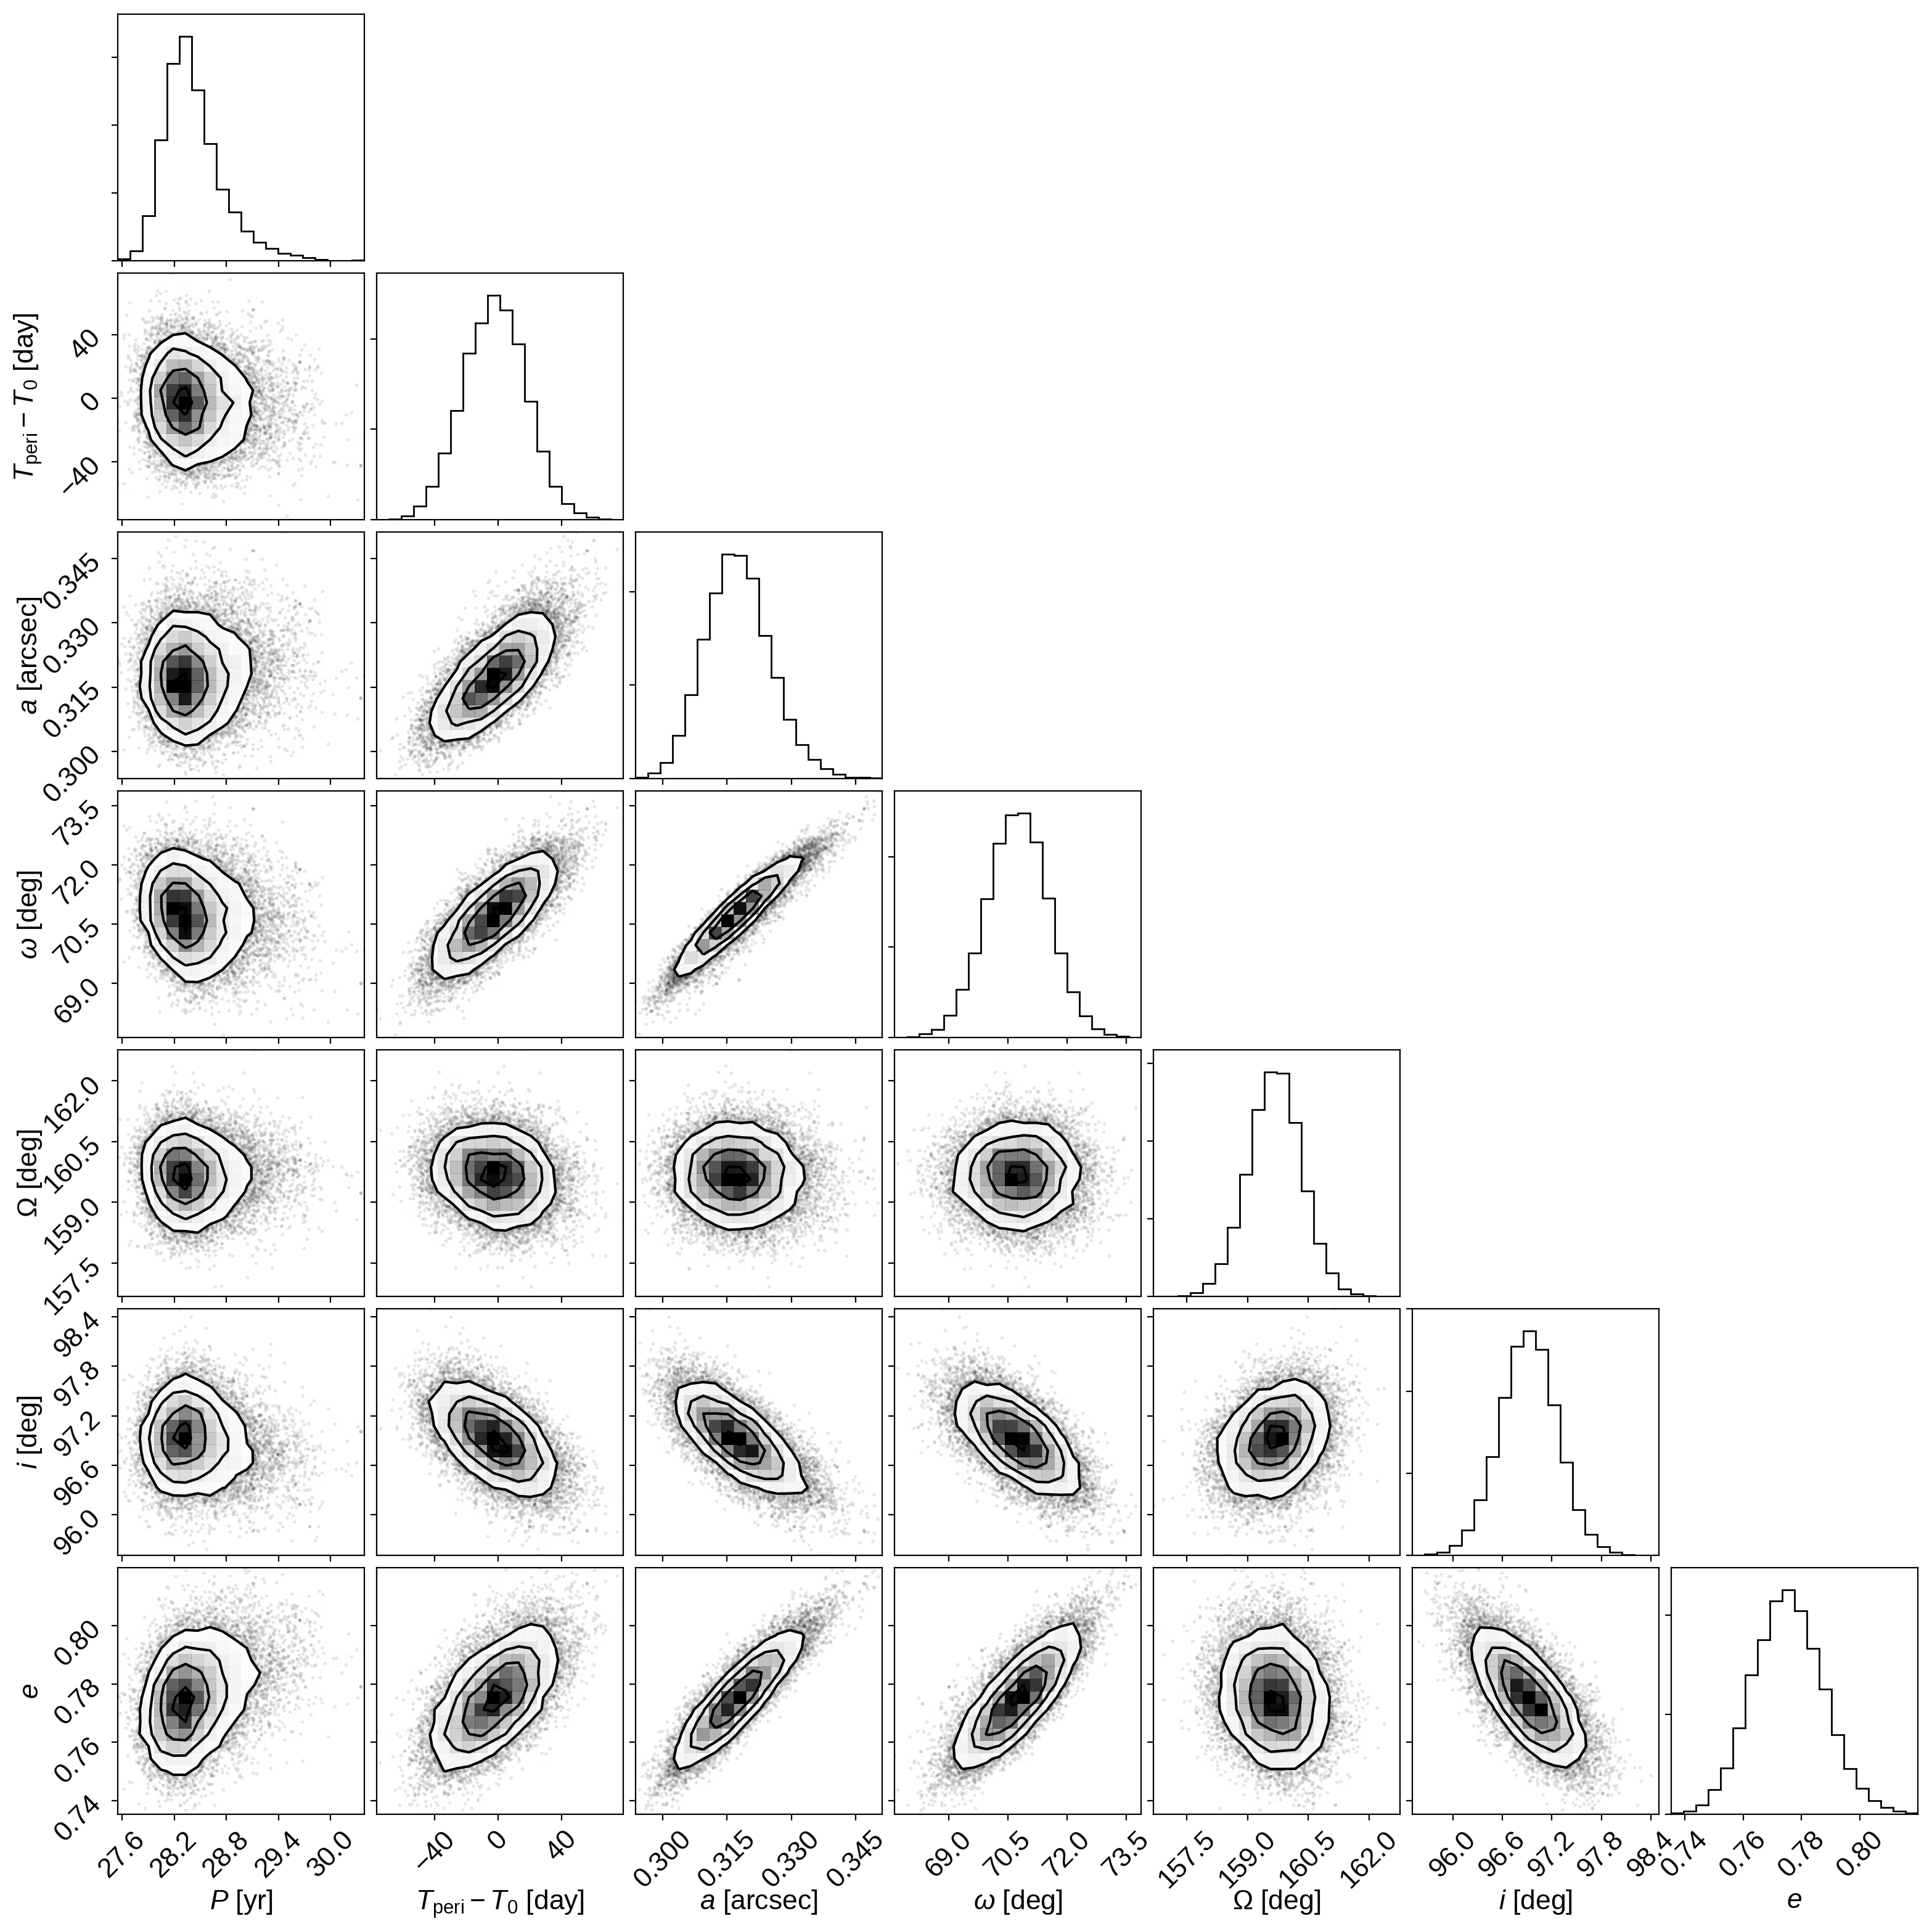

In [12]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
corner.corner(samples);

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

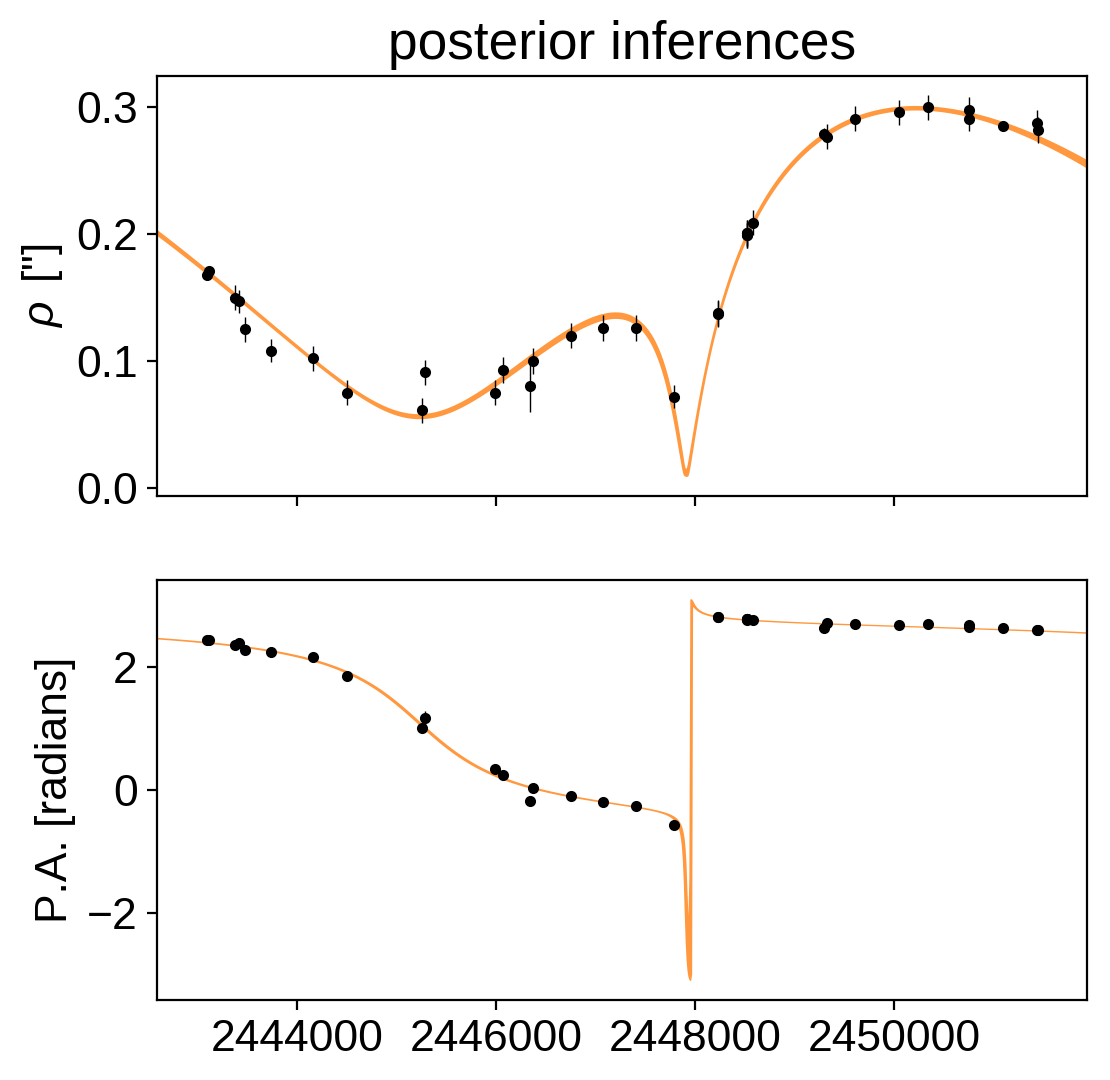

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r'P.A. [radians]')

tot_rho_err = np.sqrt(rho_err**2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0)))
tot_theta_err = np.sqrt(theta_err**2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0)))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
ax[0].set_title("posterior inferences");

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem. 

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: ['log_theta_s', 'log_rho_s']


message: Optimization terminated successfully.
logp: 107.6401502957619 -> 149.92860106268094


optimizing logp for variables: ['phase_angle__']


message: Optimization terminated successfully.
logp: 149.92860106268094 -> 170.426815184602


optimizing logp for variables: ['ecc_interval__', 'm_angle__', 'p_angle__']


message: Optimization terminated successfully.
logp: 170.426815184602 -> 212.84801588560703


optimizing logp for variables: ['phase_angle__', 'a_ang_interval__', 'logP']


message: Optimization terminated successfully.
logp: 212.84801588560703 -> 213.28597909410678


optimizing logp for variables: ['log_theta_s', 'log_rho_s', 'ecc_interval__', 'cos_incl_interval__', 'phase_angle__', 'm_angle__', 'p_angle__', 'logP', 'a_ang_interval__', 'm_plx_interval__']


message: Optimization terminated successfully.
logp: 213.28597909410678 -> 217.80586833502502


In [15]:
np.random.seed(5432)
plx_sampler = xo.PyMC3Sampler(start=200, window=100, finish=500)
with plx_model:
    burnin = plx_sampler.tune(tune=4500, start=plx_map_soln,
                          step_kwargs=dict(target_accept=0.9))
    plx_trace = plx_sampler.sample(draws=4000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:06, 127.23draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:08, 90.06draws/s] 

Sampling 4 chains:   3%|▎         | 27/808 [00:00<00:10, 72.48draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:00<00:11, 67.35draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:00<00:12, 61.23draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:12, 60.39draws/s]

Sampling 4 chains:   7%|▋         | 54/808 [00:00<00:12, 58.86draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:01<00:13, 56.38draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:01<00:11, 61.81draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:01<00:12, 57.07draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:01<00:13, 54.35draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:01<00:12, 58.07draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:01<00:13, 53.53draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:01<00:12, 54.93draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:01<00:11, 58.70draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:01<00:12, 54.49draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:02<00:13, 52.51draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:02<00:12, 56.29draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:02<00:13, 50.51draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:02<00:12, 52.63draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:02<00:12, 53.45draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:02<00:11, 58.35draws/s]

Sampling 4 chains:  21%|██        | 167/808 [00:02<00:10, 58.34draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:02<00:10, 59.90draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:03<00:11, 55.07draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:03<00:10, 58.40draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:03<00:10, 58.61draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:03<00:11, 52.66draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:03<00:10, 56.13draws/s]

Sampling 4 chains:  27%|██▋       | 216/808 [00:03<00:10, 56.09draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:03<00:10, 56.58draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:03<00:10, 57.71draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:04<00:09, 58.12draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:04<00:09, 58.14draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:04<00:09, 57.76draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:04<00:09, 56.31draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:04<00:10, 54.39draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:04<00:09, 54.32draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:04<00:09, 54.74draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:04<00:09, 55.71draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:04<00:09, 53.81draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:05<00:09, 53.58draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:05<00:09, 52.54draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:05<00:09, 55.27draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:05<00:09, 53.79draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:05<00:08, 57.19draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:05<00:08, 56.81draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:05<00:08, 56.36draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:05<00:08, 56.88draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:06<00:07, 59.69draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:06<00:07, 57.03draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:06<00:07, 62.32draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:06<00:07, 61.23draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:06<00:07, 59.17draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [00:06<00:07, 59.94draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:06<00:07, 56.10draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:06<00:07, 57.15draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:07<00:07, 53.01draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:07<00:07, 54.96draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:07<00:07, 54.15draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:07<00:06, 55.09draws/s]

Sampling 4 chains:  54%|█████▍    | 436/808 [00:07<00:06, 58.90draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [00:07<00:06, 60.70draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:07<00:05, 64.31draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:07<00:05, 60.05draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [00:08<00:05, 61.57draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:08<00:05, 58.46draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [00:08<00:05, 55.97draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:08<00:05, 59.42draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:08<00:05, 56.79draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [00:08<00:05, 58.37draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:08<00:05, 57.30draws/s]

Sampling 4 chains:  64%|██████▍   | 516/808 [00:08<00:05, 57.53draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:09<00:04, 59.61draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:09<00:04, 59.17draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [00:09<00:04, 57.13draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:09<00:04, 57.32draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:09<00:04, 57.05draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:09<00:04, 53.28draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:09<00:04, 54.02draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [00:09<00:04, 54.32draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [00:09<00:04, 55.83draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:10<00:04, 50.70draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:10<00:04, 55.20draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:10<00:04, 51.27draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:10<00:03, 55.66draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:10<00:03, 51.32draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:10<00:03, 53.31draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:10<00:03, 53.59draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:10<00:03, 51.94draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [00:11<00:03, 52.32draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:11<00:03, 56.48draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [00:11<00:02, 56.20draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:11<00:02, 55.86draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:11<00:02, 58.10draws/s]

Sampling 4 chains:  82%|████████▏ | 662/808 [00:11<00:02, 54.68draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:11<00:02, 59.56draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [00:11<00:02, 56.24draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [00:11<00:01, 61.52draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [00:12<00:01, 58.25draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:12<00:01, 58.64draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [00:12<00:01, 59.08draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:12<00:01, 55.53draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [00:12<00:01, 55.65draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:12<00:01, 58.43draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [00:12<00:01, 57.85draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:12<00:01, 60.61draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:13<00:01, 55.24draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [00:13<00:00, 58.79draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:13<00:00, 55.72draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [00:13<00:00, 54.44draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:13<00:00, 58.15draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:13<00:00, 52.67draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:13<00:00, 51.38draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:13<00:00, 52.03draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:14<00:00, 51.11draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:14<00:00, 28.92draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:14<00:00, 55.53draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 13/408 [00:00<00:03, 102.41draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:04, 77.42draws/s] 

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:04, 77.72draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:00<00:05, 64.66draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:00<00:05, 65.27draws/s]

Sampling 4 chains:  12%|█▏        | 48/408 [00:00<00:05, 61.35draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:00<00:05, 62.25draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:00<00:05, 63.28draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:01<00:05, 63.54draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:01<00:05, 61.63draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:01<00:05, 55.46draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:01<00:05, 54.61draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:01<00:05, 60.42draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:01<00:04, 60.81draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:01<00:04, 61.64draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:01<00:04, 63.94draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:02<00:04, 63.31draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:02<00:04, 63.76draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:02<00:04, 63.03draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:02<00:04, 62.93draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:02<00:03, 62.98draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:02<00:03, 65.96draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:02<00:03, 67.04draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:02<00:03, 68.18draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:02<00:03, 70.82draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:03<00:03, 69.20draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:03<00:03, 65.55draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:03<00:02, 67.68draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:03<00:02, 68.68draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:03<00:02, 67.76draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:03<00:02, 67.91draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:03<00:02, 71.67draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:03<00:02, 65.10draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:04<00:02, 70.42draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:04<00:01, 69.75draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:04<00:01, 70.71draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:04<00:01, 68.99draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:04<00:01, 68.15draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:04<00:01, 65.98draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:04<00:01, 63.39draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:04<00:01, 65.17draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:04<00:01, 62.81draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:05<00:01, 68.19draws/s]

Sampling 4 chains:  84%|████████▍ | 344/408 [00:05<00:00, 64.33draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:05<00:00, 72.50draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:05<00:00, 80.22draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:05<00:00, 78.46draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:05<00:00, 69.83draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:05<00:00, 62.95draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:06<00:00, 54.22draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:06<00:00, 30.42draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:06<00:00, 61.84draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:00<00:01, 417.13draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:00<00:01, 461.49draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:00<00:01, 488.46draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:00<00:01, 485.33draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:00<00:01, 526.84draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:00<00:00, 548.61draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:00<00:00, 572.03draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [00:00<00:00, 578.12draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:00<00:00, 592.97draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:01<00:00, 614.96draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:01<00:00, 630.36draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:01<00:00, 580.08draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:01<00:00, 474.25draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:01<00:00, 521.59draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:00<00:04, 373.69draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:00<00:04, 341.64draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:00<00:04, 315.07draws/s]

Sampling 4 chains:   7%|▋         | 117/1608 [00:00<00:05, 277.24draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:00<00:04, 305.04draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:00<00:04, 335.28draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:00<00:04, 328.80draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:00<00:03, 341.99draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:00<00:03, 352.44draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:01<00:03, 386.03draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:01<00:03, 386.48draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:01<00:02, 414.54draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:01<00:02, 453.59draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:01<00:02, 480.55draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:01<00:02, 486.72draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:01<00:01, 479.83draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:01<00:01, 485.89draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [00:01<00:01, 505.38draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [00:01<00:01, 521.55draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [00:02<00:01, 516.12draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [00:02<00:01, 529.10draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [00:02<00:01, 546.68draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [00:02<00:01, 521.93draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [00:02<00:00, 547.68draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [00:02<00:00, 548.93draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [00:02<00:00, 535.50draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [00:02<00:00, 540.68draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [00:02<00:00, 524.54draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [00:03<00:00, 492.88draws/s]

Sampling 4 chains:  90%|█████████ | 1448/1608 [00:03<00:00, 502.84draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [00:03<00:00, 501.51draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [00:03<00:00, 500.61draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [00:03<00:00, 332.48draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:03<00:00, 436.96draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 35/3208 [00:00<00:09, 333.83draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:00<00:10, 303.21draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:00<00:10, 293.77draws/s]

Sampling 4 chains:   4%|▎         | 115/3208 [00:00<00:11, 275.88draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:00<00:10, 283.85draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:00<00:11, 271.49draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:00<00:09, 306.43draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:00<00:09, 299.41draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:00<00:09, 314.06draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:01<00:08, 338.23draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:01<00:07, 371.80draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:01<00:06, 407.90draws/s]

Sampling 4 chains:  15%|█▍        | 469/3208 [00:01<00:06, 412.64draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [00:01<00:06, 419.30draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:01<00:06, 434.21draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [00:01<00:06, 418.99draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:01<00:05, 430.56draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [00:01<00:05, 433.15draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [00:01<00:05, 433.91draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [00:02<00:05, 455.77draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [00:02<00:05, 443.23draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [00:02<00:05, 450.42draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [00:02<00:04, 466.20draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [00:02<00:04, 451.57draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [00:02<00:04, 474.18draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [00:02<00:04, 480.57draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [00:02<00:04, 486.99draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [00:02<00:04, 490.68draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [00:03<00:04, 464.37draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [00:03<00:03, 501.31draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [00:03<00:03, 513.68draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [00:03<00:03, 485.85draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [00:03<00:03, 488.81draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [00:03<00:03, 481.07draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [00:03<00:03, 483.29draws/s]

Sampling 4 chains:  50%|█████     | 1612/3208 [00:03<00:03, 478.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [00:03<00:03, 475.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [00:03<00:03, 457.87draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [00:04<00:03, 455.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [00:04<00:03, 450.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [00:04<00:02, 472.74draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [00:04<00:02, 485.18draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [00:04<00:02, 485.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [00:04<00:02, 501.81draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [00:04<00:02, 528.91draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [00:04<00:02, 494.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [00:04<00:02, 463.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [00:05<00:02, 464.32draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [00:05<00:01, 467.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [00:05<00:01, 463.60draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [00:05<00:01, 478.38draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [00:05<00:01, 489.45draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [00:05<00:01, 489.13draws/s]

Sampling 4 chains:  79%|███████▊  | 2526/3208 [00:05<00:01, 464.39draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [00:05<00:01, 444.31draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [00:05<00:01, 451.30draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [00:05<00:01, 476.31draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [00:06<00:00, 508.63draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [00:06<00:00, 508.64draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [00:06<00:00, 485.23draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [00:06<00:00, 479.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [00:06<00:00, 469.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [00:06<00:00, 468.42draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [00:06<00:00, 390.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [00:06<00:00, 362.96draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [00:07<00:00, 362.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [00:07<00:00, 280.87draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [00:07<00:00, 262.34draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [00:07<00:00, 424.69draws/s]

Sampling 4 chains:   0%|          | 0/11208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 34/11208 [00:00<00:33, 337.10draws/s]

Sampling 4 chains:   1%|          | 78/11208 [00:00<00:30, 361.60draws/s]

Sampling 4 chains:   1%|          | 100/11208 [00:00<00:37, 297.65draws/s]

Sampling 4 chains:   1%|          | 133/11208 [00:00<00:36, 306.41draws/s]

Sampling 4 chains:   2%|▏         | 174/11208 [00:00<00:33, 328.60draws/s]

Sampling 4 chains:   2%|▏         | 225/11208 [00:00<00:29, 366.75draws/s]

Sampling 4 chains:   2%|▏         | 263/11208 [00:00<00:29, 370.46draws/s]

Sampling 4 chains:   3%|▎         | 311/11208 [00:00<00:27, 396.83draws/s]

Sampling 4 chains:   3%|▎         | 356/11208 [00:00<00:26, 409.87draws/s]

Sampling 4 chains:   4%|▎         | 397/11208 [00:01<00:26, 403.49draws/s]

Sampling 4 chains:   4%|▍         | 449/11208 [00:01<00:24, 432.13draws/s]

Sampling 4 chains:   4%|▍         | 493/11208 [00:01<00:25, 424.59draws/s]

Sampling 4 chains:   5%|▍         | 541/11208 [00:01<00:24, 438.57draws/s]

Sampling 4 chains:   5%|▌         | 586/11208 [00:01<00:24, 440.76draws/s]

Sampling 4 chains:   6%|▌         | 634/11208 [00:01<00:23, 450.60draws/s]

Sampling 4 chains:   6%|▌         | 680/11208 [00:01<00:23, 452.71draws/s]

Sampling 4 chains:   6%|▋         | 726/11208 [00:01<00:24, 432.67draws/s]

Sampling 4 chains:   7%|▋         | 770/11208 [00:01<00:24, 431.93draws/s]

Sampling 4 chains:   7%|▋         | 826/11208 [00:01<00:22, 463.58draws/s]

Sampling 4 chains:   8%|▊         | 882/11208 [00:02<00:21, 485.24draws/s]

Sampling 4 chains:   8%|▊         | 932/11208 [00:02<00:21, 472.55draws/s]

Sampling 4 chains:   9%|▊         | 980/11208 [00:02<00:21, 470.49draws/s]

Sampling 4 chains:   9%|▉         | 1029/11208 [00:02<00:21, 474.55draws/s]

Sampling 4 chains:  10%|▉         | 1081/11208 [00:02<00:20, 485.14draws/s]

Sampling 4 chains:  10%|█         | 1133/11208 [00:02<00:20, 494.63draws/s]

Sampling 4 chains:  11%|█         | 1186/11208 [00:02<00:19, 504.29draws/s]

Sampling 4 chains:  11%|█         | 1237/11208 [00:02<00:20, 480.51draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11208 [00:02<00:20, 485.88draws/s]

Sampling 4 chains:  12%|█▏        | 1343/11208 [00:02<00:19, 505.12draws/s]

Sampling 4 chains:  12%|█▏        | 1394/11208 [00:03<00:20, 481.30draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11208 [00:03<00:19, 491.02draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11208 [00:03<00:18, 516.75draws/s]

Sampling 4 chains:  14%|█▍        | 1558/11208 [00:03<00:18, 512.62draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11208 [00:03<00:18, 515.92draws/s]

Sampling 4 chains:  15%|█▍        | 1668/11208 [00:03<00:18, 529.37draws/s]

Sampling 4 chains:  15%|█▌        | 1730/11208 [00:03<00:17, 552.39draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11208 [00:03<00:17, 531.82draws/s]

Sampling 4 chains:  16%|█▋        | 1840/11208 [00:03<00:18, 514.85draws/s]

Sampling 4 chains:  17%|█▋        | 1892/11208 [00:04<00:18, 515.65draws/s]

Sampling 4 chains:  17%|█▋        | 1944/11208 [00:04<00:18, 491.15draws/s]

Sampling 4 chains:  18%|█▊        | 1996/11208 [00:04<00:18, 498.48draws/s]

Sampling 4 chains:  18%|█▊        | 2052/11208 [00:04<00:17, 509.52draws/s]

Sampling 4 chains:  19%|█▉        | 2104/11208 [00:04<00:19, 478.51draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11208 [00:04<00:17, 514.74draws/s]

Sampling 4 chains:  20%|█▉        | 2228/11208 [00:04<00:16, 539.23draws/s]

Sampling 4 chains:  20%|██        | 2284/11208 [00:04<00:16, 544.13draws/s]

Sampling 4 chains:  21%|██        | 2340/11208 [00:04<00:16, 524.11draws/s]

Sampling 4 chains:  21%|██▏       | 2394/11208 [00:05<00:16, 525.30draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11208 [00:05<00:15, 560.80draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11208 [00:05<00:15, 571.19draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11208 [00:05<00:15, 568.71draws/s]

Sampling 4 chains:  24%|██▎       | 2646/11208 [00:05<00:14, 594.30draws/s]

Sampling 4 chains:  24%|██▍       | 2707/11208 [00:05<00:14, 574.89draws/s]

Sampling 4 chains:  25%|██▍       | 2766/11208 [00:05<00:15, 548.08draws/s]

Sampling 4 chains:  25%|██▌       | 2822/11208 [00:05<00:15, 549.44draws/s]

Sampling 4 chains:  26%|██▌       | 2878/11208 [00:05<00:15, 538.35draws/s]

Sampling 4 chains:  26%|██▌       | 2933/11208 [00:05<00:16, 516.63draws/s]

Sampling 4 chains:  27%|██▋       | 2986/11208 [00:06<00:16, 492.62draws/s]

Sampling 4 chains:  27%|██▋       | 3036/11208 [00:06<00:16, 493.02draws/s]

Sampling 4 chains:  28%|██▊       | 3096/11208 [00:06<00:15, 519.65draws/s]

Sampling 4 chains:  28%|██▊       | 3149/11208 [00:06<00:15, 516.33draws/s]

Sampling 4 chains:  29%|██▊       | 3210/11208 [00:06<00:14, 538.68draws/s]

Sampling 4 chains:  29%|██▉       | 3265/11208 [00:06<00:14, 534.12draws/s]

Sampling 4 chains:  30%|██▉       | 3319/11208 [00:06<00:15, 523.61draws/s]

Sampling 4 chains:  30%|███       | 3379/11208 [00:06<00:14, 541.99draws/s]

Sampling 4 chains:  31%|███       | 3434/11208 [00:06<00:14, 534.78draws/s]

Sampling 4 chains:  31%|███       | 3488/11208 [00:07<00:14, 517.03draws/s]

Sampling 4 chains:  32%|███▏      | 3541/11208 [00:07<00:15, 509.66draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11208 [00:07<00:14, 513.78draws/s]

Sampling 4 chains:  33%|███▎      | 3647/11208 [00:07<00:14, 514.24draws/s]

Sampling 4 chains:  33%|███▎      | 3701/11208 [00:07<00:14, 519.80draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11208 [00:07<00:14, 515.37draws/s]

Sampling 4 chains:  34%|███▍      | 3806/11208 [00:07<00:14, 513.07draws/s]

Sampling 4 chains:  34%|███▍      | 3863/11208 [00:07<00:13, 527.72draws/s]

Sampling 4 chains:  35%|███▍      | 3916/11208 [00:07<00:14, 514.20draws/s]

Sampling 4 chains:  35%|███▌      | 3968/11208 [00:07<00:14, 509.64draws/s]

Sampling 4 chains:  36%|███▌      | 4020/11208 [00:08<00:14, 497.85draws/s]

Sampling 4 chains:  36%|███▋      | 4070/11208 [00:08<00:14, 488.77draws/s]

Sampling 4 chains:  37%|███▋      | 4120/11208 [00:08<00:15, 471.18draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11208 [00:08<00:14, 485.90draws/s]

Sampling 4 chains:  38%|███▊      | 4225/11208 [00:08<00:14, 495.25draws/s]

Sampling 4 chains:  38%|███▊      | 4275/11208 [00:08<00:14, 479.45draws/s]

Sampling 4 chains:  39%|███▊      | 4325/11208 [00:08<00:14, 482.20draws/s]

Sampling 4 chains:  39%|███▉      | 4374/11208 [00:08<00:14, 470.67draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11208 [00:08<00:14, 479.85draws/s]

Sampling 4 chains:  40%|███▉      | 4474/11208 [00:09<00:14, 478.47draws/s]

Sampling 4 chains:  40%|████      | 4522/11208 [00:09<00:14, 466.26draws/s]

Sampling 4 chains:  41%|████      | 4580/11208 [00:09<00:13, 495.10draws/s]

Sampling 4 chains:  41%|████▏     | 4641/11208 [00:09<00:12, 523.16draws/s]

Sampling 4 chains:  42%|████▏     | 4695/11208 [00:09<00:12, 519.14draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11208 [00:09<00:12, 513.82draws/s]

Sampling 4 chains:  43%|████▎     | 4805/11208 [00:09<00:12, 527.30draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11208 [00:09<00:12, 514.48draws/s]

Sampling 4 chains:  44%|████▍     | 4911/11208 [00:09<00:12, 487.79draws/s]

Sampling 4 chains:  44%|████▍     | 4974/11208 [00:09<00:11, 520.13draws/s]

Sampling 4 chains:  45%|████▍     | 5035/11208 [00:10<00:11, 542.98draws/s]

Sampling 4 chains:  45%|████▌     | 5097/11208 [00:10<00:10, 563.33draws/s]

Sampling 4 chains:  46%|████▌     | 5163/11208 [00:10<00:10, 585.78draws/s]

Sampling 4 chains:  47%|████▋     | 5223/11208 [00:10<00:10, 589.71draws/s]

Sampling 4 chains:  47%|████▋     | 5283/11208 [00:10<00:10, 556.55draws/s]

Sampling 4 chains:  48%|████▊     | 5343/11208 [00:10<00:10, 567.61draws/s]

Sampling 4 chains:  48%|████▊     | 5401/11208 [00:10<00:10, 554.09draws/s]

Sampling 4 chains:  49%|████▊     | 5457/11208 [00:10<00:10, 532.68draws/s]

Sampling 4 chains:  49%|████▉     | 5511/11208 [00:10<00:10, 524.48draws/s]

Sampling 4 chains:  50%|████▉     | 5564/11208 [00:11<00:10, 519.06draws/s]

Sampling 4 chains:  50%|█████     | 5617/11208 [00:11<00:10, 513.47draws/s]

Sampling 4 chains:  51%|█████     | 5669/11208 [00:11<00:10, 504.12draws/s]

Sampling 4 chains:  51%|█████     | 5726/11208 [00:11<00:10, 520.56draws/s]

Sampling 4 chains:  52%|█████▏    | 5779/11208 [00:11<00:10, 512.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5831/11208 [00:11<00:10, 496.82draws/s]

Sampling 4 chains:  53%|█████▎    | 5890/11208 [00:11<00:10, 521.44draws/s]

Sampling 4 chains:  53%|█████▎    | 5945/11208 [00:11<00:09, 528.47draws/s]

Sampling 4 chains:  54%|█████▎    | 5999/11208 [00:11<00:09, 528.21draws/s]

Sampling 4 chains:  54%|█████▍    | 6053/11208 [00:11<00:09, 531.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6115/11208 [00:12<00:09, 552.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6171/11208 [00:12<00:09, 544.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6226/11208 [00:12<00:09, 544.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6281/11208 [00:12<00:09, 528.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6335/11208 [00:12<00:09, 516.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6390/11208 [00:12<00:09, 525.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6444/11208 [00:12<00:09, 526.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6497/11208 [00:12<00:09, 506.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6550/11208 [00:12<00:09, 511.03draws/s]

Sampling 4 chains:  59%|█████▉    | 6608/11208 [00:13<00:08, 529.32draws/s]

Sampling 4 chains:  59%|█████▉    | 6662/11208 [00:13<00:08, 523.65draws/s]

Sampling 4 chains:  60%|█████▉    | 6716/11208 [00:13<00:08, 527.57draws/s]

Sampling 4 chains:  60%|██████    | 6770/11208 [00:13<00:08, 530.64draws/s]

Sampling 4 chains:  61%|██████    | 6824/11208 [00:13<00:08, 530.47draws/s]

Sampling 4 chains:  61%|██████▏   | 6878/11208 [00:13<00:08, 528.00draws/s]

Sampling 4 chains:  62%|██████▏   | 6931/11208 [00:13<00:08, 523.36draws/s]

Sampling 4 chains:  62%|██████▏   | 6984/11208 [00:13<00:08, 524.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7040/11208 [00:13<00:07, 533.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7105/11208 [00:13<00:07, 562.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7162/11208 [00:14<00:07, 563.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7219/11208 [00:14<00:07, 558.48draws/s]

Sampling 4 chains:  65%|██████▍   | 7278/11208 [00:14<00:06, 566.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7339/11208 [00:14<00:06, 575.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7397/11208 [00:14<00:06, 570.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7455/11208 [00:14<00:06, 555.54draws/s]

Sampling 4 chains:  67%|██████▋   | 7511/11208 [00:14<00:06, 554.58draws/s]

Sampling 4 chains:  68%|██████▊   | 7570/11208 [00:14<00:06, 561.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7627/11208 [00:14<00:06, 544.51draws/s]

Sampling 4 chains:  69%|██████▊   | 7682/11208 [00:15<00:06, 513.45draws/s]

Sampling 4 chains:  69%|██████▉   | 7740/11208 [00:15<00:06, 530.69draws/s]

Sampling 4 chains:  70%|██████▉   | 7794/11208 [00:15<00:06, 508.20draws/s]

Sampling 4 chains:  70%|███████   | 7846/11208 [00:15<00:06, 496.03draws/s]

Sampling 4 chains:  70%|███████   | 7897/11208 [00:15<00:06, 489.73draws/s]

Sampling 4 chains:  71%|███████   | 7947/11208 [00:15<00:06, 478.24draws/s]

Sampling 4 chains:  71%|███████▏  | 7998/11208 [00:15<00:06, 484.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8049/11208 [00:15<00:06, 490.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8104/11208 [00:15<00:06, 504.96draws/s]

Sampling 4 chains:  73%|███████▎  | 8161/11208 [00:15<00:05, 521.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8221/11208 [00:16<00:05, 540.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8276/11208 [00:16<00:05, 531.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8330/11208 [00:16<00:05, 530.64draws/s]

Sampling 4 chains:  75%|███████▍  | 8391/11208 [00:16<00:05, 549.86draws/s]

Sampling 4 chains:  75%|███████▌  | 8448/11208 [00:16<00:04, 554.69draws/s]

Sampling 4 chains:  76%|███████▌  | 8504/11208 [00:16<00:04, 543.14draws/s]

Sampling 4 chains:  76%|███████▋  | 8560/11208 [00:16<00:04, 548.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8615/11208 [00:16<00:05, 517.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8668/11208 [00:16<00:04, 514.67draws/s]

Sampling 4 chains:  78%|███████▊  | 8720/11208 [00:17<00:04, 501.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8771/11208 [00:17<00:04, 498.07draws/s]

Sampling 4 chains:  79%|███████▊  | 8822/11208 [00:17<00:04, 495.76draws/s]

Sampling 4 chains:  79%|███████▉  | 8873/11208 [00:17<00:04, 497.99draws/s]

Sampling 4 chains:  80%|███████▉  | 8925/11208 [00:17<00:04, 502.95draws/s]

Sampling 4 chains:  80%|████████  | 8976/11208 [00:17<00:04, 468.24draws/s]

Sampling 4 chains:  81%|████████  | 9027/11208 [00:17<00:04, 477.98draws/s]

Sampling 4 chains:  81%|████████  | 9082/11208 [00:17<00:04, 494.60draws/s]

Sampling 4 chains:  81%|████████▏ | 9132/11208 [00:17<00:04, 481.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9181/11208 [00:17<00:04, 467.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9238/11208 [00:18<00:04, 492.17draws/s]

Sampling 4 chains:  83%|████████▎ | 9295/11208 [00:18<00:03, 511.92draws/s]

Sampling 4 chains:  83%|████████▎ | 9347/11208 [00:18<00:03, 510.56draws/s]

Sampling 4 chains:  84%|████████▍ | 9399/11208 [00:18<00:03, 502.50draws/s]

Sampling 4 chains:  84%|████████▍ | 9450/11208 [00:18<00:03, 501.31draws/s]

Sampling 4 chains:  85%|████████▍ | 9501/11208 [00:18<00:03, 481.27draws/s]

Sampling 4 chains:  85%|████████▌ | 9550/11208 [00:18<00:03, 483.58draws/s]

Sampling 4 chains:  86%|████████▌ | 9606/11208 [00:18<00:03, 503.06draws/s]

Sampling 4 chains:  86%|████████▋ | 9667/11208 [00:18<00:02, 529.06draws/s]

Sampling 4 chains:  87%|████████▋ | 9722/11208 [00:19<00:02, 529.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9776/11208 [00:19<00:02, 524.85draws/s]

Sampling 4 chains:  88%|████████▊ | 9829/11208 [00:19<00:02, 523.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9882/11208 [00:19<00:02, 520.72draws/s]

Sampling 4 chains:  89%|████████▊ | 9935/11208 [00:19<00:02, 515.75draws/s]

Sampling 4 chains:  89%|████████▉ | 9989/11208 [00:19<00:02, 521.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10045/11208 [00:19<00:02, 532.57draws/s]

Sampling 4 chains:  90%|█████████ | 10099/11208 [00:19<00:02, 530.75draws/s]

Sampling 4 chains:  91%|█████████ | 10157/11208 [00:19<00:01, 543.40draws/s]

Sampling 4 chains:  91%|█████████ | 10212/11208 [00:19<00:01, 536.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10266/11208 [00:20<00:01, 536.36draws/s]

Sampling 4 chains:  92%|█████████▏| 10326/11208 [00:20<00:01, 551.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10394/11208 [00:20<00:01, 583.80draws/s]

Sampling 4 chains:  93%|█████████▎| 10456/11208 [00:20<00:01, 593.71draws/s]

Sampling 4 chains:  94%|█████████▍| 10520/11208 [00:20<00:01, 605.45draws/s]

Sampling 4 chains:  94%|█████████▍| 10581/11208 [00:20<00:01, 555.57draws/s]

Sampling 4 chains:  95%|█████████▍| 10638/11208 [00:20<00:01, 528.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10692/11208 [00:20<00:01, 513.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10748/11208 [00:20<00:00, 524.34draws/s]

Sampling 4 chains:  96%|█████████▋| 10808/11208 [00:21<00:00, 544.87draws/s]

Sampling 4 chains:  97%|█████████▋| 10864/11208 [00:21<00:00, 526.59draws/s]

Sampling 4 chains:  97%|█████████▋| 10918/11208 [00:21<00:00, 426.18draws/s]

Sampling 4 chains:  98%|█████████▊| 10965/11208 [00:21<00:00, 429.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11011/11208 [00:21<00:00, 310.68draws/s]

Sampling 4 chains:  99%|█████████▊| 11049/11208 [00:21<00:00, 305.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11085/11208 [00:21<00:00, 304.53draws/s]

Sampling 4 chains:  99%|█████████▉| 11119/11208 [00:22<00:00, 299.00draws/s]

Sampling 4 chains: 100%|█████████▉| 11152/11208 [00:22<00:00, 292.35draws/s]

Sampling 4 chains: 100%|█████████▉| 11183/11208 [00:22<00:00, 254.48draws/s]

Sampling 4 chains: 100%|██████████| 11208/11208 [00:22<00:00, 496.51draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:00<00:07, 277.61draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:00<00:07, 255.65draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:00<00:10, 177.81draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:00<00:09, 209.08draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:00<00:07, 243.33draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:00<00:06, 280.36draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:00<00:05, 300.09draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:00<00:05, 329.37draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:00<00:05, 326.10draws/s]

Sampling 4 chains:  17%|█▋        | 336/2008 [00:01<00:05, 320.62draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:01<00:05, 319.59draws/s]

Sampling 4 chains:  20%|██        | 406/2008 [00:01<00:04, 330.36draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:01<00:04, 346.41draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [00:01<00:03, 379.14draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:01<00:03, 401.67draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [00:01<00:03, 420.14draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [00:01<00:03, 408.57draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [00:01<00:03, 422.63draws/s]

Sampling 4 chains:  36%|███▋      | 730/2008 [00:01<00:02, 442.62draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [00:02<00:02, 412.17draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [00:02<00:02, 437.21draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [00:02<00:02, 423.05draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [00:02<00:02, 437.33draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [00:02<00:02, 455.23draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [00:02<00:02, 477.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [00:02<00:02, 466.48draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [00:02<00:01, 449.47draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [00:02<00:01, 444.36draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [00:03<00:01, 454.12draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [00:03<00:01, 457.62draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [00:03<00:01, 469.40draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [00:03<00:01, 480.03draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [00:03<00:01, 478.45draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [00:03<00:01, 480.17draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [00:03<00:01, 469.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [00:03<00:00, 472.58draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [00:03<00:00, 497.94draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [00:04<00:00, 497.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [00:04<00:00, 506.50draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [00:04<00:00, 508.75draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [00:04<00:00, 497.92draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [00:04<00:00, 449.17draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [00:04<00:00, 476.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [00:04<00:00, 340.98draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [00:04<00:00, 405.80draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 33/16000 [00:00<00:48, 325.93draws/s]

Sampling 4 chains:   1%|          | 88/16000 [00:00<00:42, 370.80draws/s]

Sampling 4 chains:   1%|          | 142/16000 [00:00<00:38, 407.93draws/s]

Sampling 4 chains:   1%|          | 193/16000 [00:00<00:36, 433.61draws/s]

Sampling 4 chains:   2%|▏         | 247/16000 [00:00<00:34, 459.97draws/s]

Sampling 4 chains:   2%|▏         | 301/16000 [00:00<00:32, 479.66draws/s]

Sampling 4 chains:   2%|▏         | 358/16000 [00:00<00:31, 503.37draws/s]

Sampling 4 chains:   3%|▎         | 418/16000 [00:00<00:29, 526.78draws/s]

Sampling 4 chains:   3%|▎         | 471/16000 [00:00<00:29, 518.21draws/s]

Sampling 4 chains:   3%|▎         | 525/16000 [00:01<00:29, 522.67draws/s]

Sampling 4 chains:   4%|▎         | 584/16000 [00:01<00:28, 538.91draws/s]

Sampling 4 chains:   4%|▍         | 638/16000 [00:01<00:28, 533.00draws/s]

Sampling 4 chains:   4%|▍         | 692/16000 [00:01<00:29, 526.58draws/s]

Sampling 4 chains:   5%|▍         | 751/16000 [00:01<00:28, 543.09draws/s]

Sampling 4 chains:   5%|▌         | 807/16000 [00:01<00:27, 545.75draws/s]

Sampling 4 chains:   5%|▌         | 862/16000 [00:01<00:28, 535.74draws/s]

Sampling 4 chains:   6%|▌         | 917/16000 [00:01<00:28, 537.44draws/s]

Sampling 4 chains:   6%|▌         | 972/16000 [00:01<00:27, 539.88draws/s]

Sampling 4 chains:   6%|▋         | 1031/16000 [00:01<00:27, 552.28draws/s]

Sampling 4 chains:   7%|▋         | 1089/16000 [00:02<00:26, 557.67draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [00:02<00:26, 560.20draws/s]

Sampling 4 chains:   8%|▊         | 1204/16000 [00:02<00:26, 548.18draws/s]

Sampling 4 chains:   8%|▊         | 1259/16000 [00:02<00:28, 525.49draws/s]

Sampling 4 chains:   8%|▊         | 1314/16000 [00:02<00:27, 531.22draws/s]

Sampling 4 chains:   9%|▊         | 1368/16000 [00:02<00:27, 524.97draws/s]

Sampling 4 chains:   9%|▉         | 1423/16000 [00:02<00:27, 531.28draws/s]

Sampling 4 chains:   9%|▉         | 1477/16000 [00:02<00:27, 522.24draws/s]

Sampling 4 chains:  10%|▉         | 1532/16000 [00:02<00:27, 529.72draws/s]

Sampling 4 chains:  10%|▉         | 1586/16000 [00:02<00:27, 528.38draws/s]

Sampling 4 chains:  10%|█         | 1639/16000 [00:03<00:27, 514.58draws/s]

Sampling 4 chains:  11%|█         | 1691/16000 [00:03<00:28, 503.32draws/s]

Sampling 4 chains:  11%|█         | 1747/16000 [00:03<00:27, 518.64draws/s]

Sampling 4 chains:  11%|█▏        | 1802/16000 [00:03<00:26, 526.00draws/s]

Sampling 4 chains:  12%|█▏        | 1855/16000 [00:03<00:27, 520.87draws/s]

Sampling 4 chains:  12%|█▏        | 1911/16000 [00:03<00:26, 531.84draws/s]

Sampling 4 chains:  12%|█▏        | 1967/16000 [00:03<00:26, 538.12draws/s]

Sampling 4 chains:  13%|█▎        | 2025/16000 [00:03<00:25, 549.38draws/s]

Sampling 4 chains:  13%|█▎        | 2081/16000 [00:03<00:25, 535.57draws/s]

Sampling 4 chains:  13%|█▎        | 2135/16000 [00:04<00:26, 531.20draws/s]

Sampling 4 chains:  14%|█▎        | 2189/16000 [00:04<00:25, 531.33draws/s]

Sampling 4 chains:  14%|█▍        | 2244/16000 [00:04<00:25, 534.32draws/s]

Sampling 4 chains:  14%|█▍        | 2298/16000 [00:04<00:25, 535.98draws/s]

Sampling 4 chains:  15%|█▍        | 2352/16000 [00:04<00:25, 529.57draws/s]

Sampling 4 chains:  15%|█▌        | 2406/16000 [00:04<00:25, 530.58draws/s]

Sampling 4 chains:  15%|█▌        | 2460/16000 [00:04<00:26, 518.72draws/s]

Sampling 4 chains:  16%|█▌        | 2516/16000 [00:04<00:25, 530.28draws/s]

Sampling 4 chains:  16%|█▌        | 2571/16000 [00:04<00:25, 535.97draws/s]

Sampling 4 chains:  16%|█▋        | 2625/16000 [00:04<00:25, 528.14draws/s]

Sampling 4 chains:  17%|█▋        | 2678/16000 [00:05<00:25, 522.81draws/s]

Sampling 4 chains:  17%|█▋        | 2731/16000 [00:05<00:25, 524.80draws/s]

Sampling 4 chains:  17%|█▋        | 2786/16000 [00:05<00:24, 530.74draws/s]

Sampling 4 chains:  18%|█▊        | 2845/16000 [00:05<00:24, 545.01draws/s]

Sampling 4 chains:  18%|█▊        | 2902/16000 [00:05<00:23, 551.19draws/s]

Sampling 4 chains:  18%|█▊        | 2958/16000 [00:05<00:23, 548.20draws/s]

Sampling 4 chains:  19%|█▉        | 3014/16000 [00:05<00:23, 551.17draws/s]

Sampling 4 chains:  19%|█▉        | 3073/16000 [00:05<00:23, 560.25draws/s]

Sampling 4 chains:  20%|█▉        | 3130/16000 [00:05<00:23, 558.72draws/s]

Sampling 4 chains:  20%|█▉        | 3187/16000 [00:05<00:22, 560.16draws/s]

Sampling 4 chains:  20%|██        | 3247/16000 [00:06<00:22, 569.93draws/s]

Sampling 4 chains:  21%|██        | 3305/16000 [00:06<00:22, 559.65draws/s]

Sampling 4 chains:  21%|██        | 3362/16000 [00:06<00:22, 554.91draws/s]

Sampling 4 chains:  21%|██▏       | 3418/16000 [00:06<00:23, 535.57draws/s]

Sampling 4 chains:  22%|██▏       | 3472/16000 [00:06<00:23, 532.06draws/s]

Sampling 4 chains:  22%|██▏       | 3530/16000 [00:06<00:22, 544.50draws/s]

Sampling 4 chains:  22%|██▏       | 3586/16000 [00:06<00:22, 547.77draws/s]

Sampling 4 chains:  23%|██▎       | 3645/16000 [00:06<00:22, 558.42draws/s]

Sampling 4 chains:  23%|██▎       | 3701/16000 [00:06<00:22, 545.94draws/s]

Sampling 4 chains:  23%|██▎       | 3756/16000 [00:07<00:22, 533.86draws/s]

Sampling 4 chains:  24%|██▍       | 3815/16000 [00:07<00:22, 548.41draws/s]

Sampling 4 chains:  24%|██▍       | 3877/16000 [00:07<00:21, 562.47draws/s]

Sampling 4 chains:  25%|██▍       | 3934/16000 [00:07<00:21, 549.68draws/s]

Sampling 4 chains:  25%|██▍       | 3991/16000 [00:07<00:21, 551.75draws/s]

Sampling 4 chains:  25%|██▌       | 4047/16000 [00:07<00:23, 514.02draws/s]

Sampling 4 chains:  26%|██▌       | 4106/16000 [00:07<00:22, 532.40draws/s]

Sampling 4 chains:  26%|██▌       | 4160/16000 [00:07<00:22, 532.76draws/s]

Sampling 4 chains:  26%|██▋       | 4214/16000 [00:07<00:22, 530.56draws/s]

Sampling 4 chains:  27%|██▋       | 4268/16000 [00:07<00:22, 524.66draws/s]

Sampling 4 chains:  27%|██▋       | 4324/16000 [00:08<00:21, 534.21draws/s]

Sampling 4 chains:  27%|██▋       | 4380/16000 [00:08<00:21, 537.28draws/s]

Sampling 4 chains:  28%|██▊       | 4437/16000 [00:08<00:21, 544.99draws/s]

Sampling 4 chains:  28%|██▊       | 4492/16000 [00:08<00:21, 529.73draws/s]

Sampling 4 chains:  28%|██▊       | 4546/16000 [00:08<00:22, 518.75draws/s]

Sampling 4 chains:  29%|██▊       | 4599/16000 [00:08<00:22, 518.15draws/s]

Sampling 4 chains:  29%|██▉       | 4651/16000 [00:08<00:21, 517.27draws/s]

Sampling 4 chains:  29%|██▉       | 4705/16000 [00:08<00:21, 523.48draws/s]

Sampling 4 chains:  30%|██▉       | 4758/16000 [00:08<00:22, 508.59draws/s]

Sampling 4 chains:  30%|███       | 4812/16000 [00:09<00:21, 517.11draws/s]

Sampling 4 chains:  30%|███       | 4867/16000 [00:09<00:21, 526.28draws/s]

Sampling 4 chains:  31%|███       | 4921/16000 [00:09<00:20, 529.79draws/s]

Sampling 4 chains:  31%|███       | 4975/16000 [00:09<00:21, 521.24draws/s]

Sampling 4 chains:  31%|███▏      | 5028/16000 [00:09<00:21, 518.22draws/s]

Sampling 4 chains:  32%|███▏      | 5080/16000 [00:09<00:21, 501.32draws/s]

Sampling 4 chains:  32%|███▏      | 5136/16000 [00:09<00:21, 516.49draws/s]

Sampling 4 chains:  32%|███▏      | 5188/16000 [00:09<00:20, 516.64draws/s]

Sampling 4 chains:  33%|███▎      | 5243/16000 [00:09<00:20, 524.74draws/s]

Sampling 4 chains:  33%|███▎      | 5298/16000 [00:09<00:20, 527.66draws/s]

Sampling 4 chains:  33%|███▎      | 5351/16000 [00:10<00:20, 525.05draws/s]

Sampling 4 chains:  34%|███▍      | 5404/16000 [00:10<00:20, 516.61draws/s]

Sampling 4 chains:  34%|███▍      | 5457/16000 [00:10<00:20, 519.57draws/s]

Sampling 4 chains:  34%|███▍      | 5510/16000 [00:10<00:20, 521.80draws/s]

Sampling 4 chains:  35%|███▍      | 5567/16000 [00:10<00:19, 533.58draws/s]

Sampling 4 chains:  35%|███▌      | 5630/16000 [00:10<00:18, 557.18draws/s]

Sampling 4 chains:  36%|███▌      | 5690/16000 [00:10<00:18, 567.80draws/s]

Sampling 4 chains:  36%|███▌      | 5748/16000 [00:10<00:18, 557.66draws/s]

Sampling 4 chains:  36%|███▋      | 5805/16000 [00:10<00:18, 553.98draws/s]

Sampling 4 chains:  37%|███▋      | 5861/16000 [00:10<00:18, 554.78draws/s]

Sampling 4 chains:  37%|███▋      | 5917/16000 [00:11<00:18, 540.25draws/s]

Sampling 4 chains:  37%|███▋      | 5974/16000 [00:11<00:18, 547.61draws/s]

Sampling 4 chains:  38%|███▊      | 6029/16000 [00:11<00:18, 541.75draws/s]

Sampling 4 chains:  38%|███▊      | 6088/16000 [00:11<00:17, 551.23draws/s]

Sampling 4 chains:  38%|███▊      | 6144/16000 [00:11<00:18, 544.43draws/s]

Sampling 4 chains:  39%|███▊      | 6199/16000 [00:11<00:18, 541.56draws/s]

Sampling 4 chains:  39%|███▉      | 6254/16000 [00:11<00:18, 534.73draws/s]

Sampling 4 chains:  39%|███▉      | 6308/16000 [00:11<00:18, 525.78draws/s]

Sampling 4 chains:  40%|███▉      | 6361/16000 [00:11<00:18, 515.96draws/s]

Sampling 4 chains:  40%|████      | 6418/16000 [00:12<00:18, 530.46draws/s]

Sampling 4 chains:  40%|████      | 6472/16000 [00:12<00:18, 525.46draws/s]

Sampling 4 chains:  41%|████      | 6527/16000 [00:12<00:17, 532.37draws/s]

Sampling 4 chains:  41%|████      | 6584/16000 [00:12<00:17, 541.13draws/s]

Sampling 4 chains:  41%|████▏     | 6639/16000 [00:12<00:17, 533.84draws/s]

Sampling 4 chains:  42%|████▏     | 6693/16000 [00:12<00:17, 529.32draws/s]

Sampling 4 chains:  42%|████▏     | 6747/16000 [00:12<00:17, 515.88draws/s]

Sampling 4 chains:  42%|████▏     | 6799/16000 [00:12<00:17, 515.07draws/s]

Sampling 4 chains:  43%|████▎     | 6853/16000 [00:12<00:17, 522.08draws/s]

Sampling 4 chains:  43%|████▎     | 6906/16000 [00:12<00:17, 510.85draws/s]

Sampling 4 chains:  44%|████▎     | 6962/16000 [00:13<00:17, 522.85draws/s]

Sampling 4 chains:  44%|████▍     | 7015/16000 [00:13<00:17, 522.24draws/s]

Sampling 4 chains:  44%|████▍     | 7068/16000 [00:13<00:17, 513.12draws/s]

Sampling 4 chains:  44%|████▍     | 7120/16000 [00:13<00:17, 514.37draws/s]

Sampling 4 chains:  45%|████▍     | 7178/16000 [00:13<00:16, 528.43draws/s]

Sampling 4 chains:  45%|████▌     | 7231/16000 [00:13<00:16, 517.58draws/s]

Sampling 4 chains:  46%|████▌     | 7286/16000 [00:13<00:16, 526.24draws/s]

Sampling 4 chains:  46%|████▌     | 7339/16000 [00:13<00:17, 509.23draws/s]

Sampling 4 chains:  46%|████▌     | 7392/16000 [00:13<00:16, 513.90draws/s]

Sampling 4 chains:  47%|████▋     | 7446/16000 [00:13<00:16, 518.28draws/s]

Sampling 4 chains:  47%|████▋     | 7503/16000 [00:14<00:16, 530.82draws/s]

Sampling 4 chains:  47%|████▋     | 7562/16000 [00:14<00:15, 545.86draws/s]

Sampling 4 chains:  48%|████▊     | 7617/16000 [00:14<00:15, 541.47draws/s]

Sampling 4 chains:  48%|████▊     | 7672/16000 [00:14<00:15, 522.06draws/s]

Sampling 4 chains:  48%|████▊     | 7725/16000 [00:14<00:16, 506.61draws/s]

Sampling 4 chains:  49%|████▊     | 7781/16000 [00:14<00:15, 513.86draws/s]

Sampling 4 chains:  49%|████▉     | 7837/16000 [00:14<00:15, 522.84draws/s]

Sampling 4 chains:  49%|████▉     | 7893/16000 [00:14<00:15, 532.87draws/s]

Sampling 4 chains:  50%|████▉     | 7947/16000 [00:14<00:15, 519.82draws/s]

Sampling 4 chains:  50%|█████     | 8000/16000 [00:15<00:15, 516.10draws/s]

Sampling 4 chains:  50%|█████     | 8063/16000 [00:15<00:14, 543.56draws/s]

Sampling 4 chains:  51%|█████     | 8121/16000 [00:15<00:14, 553.96draws/s]

Sampling 4 chains:  51%|█████     | 8177/16000 [00:15<00:14, 535.64draws/s]

Sampling 4 chains:  51%|█████▏    | 8237/16000 [00:15<00:14, 549.38draws/s]

Sampling 4 chains:  52%|█████▏    | 8298/16000 [00:15<00:13, 564.78draws/s]

Sampling 4 chains:  52%|█████▏    | 8355/16000 [00:15<00:13, 557.49draws/s]

Sampling 4 chains:  53%|█████▎    | 8412/16000 [00:15<00:13, 544.07draws/s]

Sampling 4 chains:  53%|█████▎    | 8467/16000 [00:15<00:14, 537.36draws/s]

Sampling 4 chains:  53%|█████▎    | 8521/16000 [00:15<00:14, 518.84draws/s]

Sampling 4 chains:  54%|█████▎    | 8580/16000 [00:16<00:13, 536.85draws/s]

Sampling 4 chains:  54%|█████▍    | 8635/16000 [00:16<00:13, 528.66draws/s]

Sampling 4 chains:  54%|█████▍    | 8692/16000 [00:16<00:13, 536.37draws/s]

Sampling 4 chains:  55%|█████▍    | 8746/16000 [00:16<00:13, 532.21draws/s]

Sampling 4 chains:  55%|█████▌    | 8800/16000 [00:16<00:13, 524.01draws/s]

Sampling 4 chains:  55%|█████▌    | 8853/16000 [00:16<00:13, 515.26draws/s]

Sampling 4 chains:  56%|█████▌    | 8911/16000 [00:16<00:13, 532.48draws/s]

Sampling 4 chains:  56%|█████▌    | 8965/16000 [00:16<00:13, 523.39draws/s]

Sampling 4 chains:  56%|█████▋    | 9024/16000 [00:16<00:12, 540.16draws/s]

Sampling 4 chains:  57%|█████▋    | 9079/16000 [00:17<00:12, 533.10draws/s]

Sampling 4 chains:  57%|█████▋    | 9134/16000 [00:17<00:12, 537.03draws/s]

Sampling 4 chains:  57%|█████▋    | 9188/16000 [00:17<00:12, 535.35draws/s]

Sampling 4 chains:  58%|█████▊    | 9245/16000 [00:17<00:12, 544.44draws/s]

Sampling 4 chains:  58%|█████▊    | 9303/16000 [00:17<00:12, 552.85draws/s]

Sampling 4 chains:  58%|█████▊    | 9360/16000 [00:17<00:11, 554.87draws/s]

Sampling 4 chains:  59%|█████▉    | 9416/16000 [00:17<00:12, 546.72draws/s]

Sampling 4 chains:  59%|█████▉    | 9471/16000 [00:17<00:12, 534.68draws/s]

Sampling 4 chains:  60%|█████▉    | 9525/16000 [00:17<00:12, 529.72draws/s]

Sampling 4 chains:  60%|█████▉    | 9579/16000 [00:17<00:12, 512.68draws/s]

Sampling 4 chains:  60%|██████    | 9639/16000 [00:18<00:11, 534.03draws/s]

Sampling 4 chains:  61%|██████    | 9695/16000 [00:18<00:11, 541.00draws/s]

Sampling 4 chains:  61%|██████    | 9750/16000 [00:18<00:11, 531.41draws/s]

Sampling 4 chains:  61%|██████▏   | 9808/16000 [00:18<00:11, 542.80draws/s]

Sampling 4 chains:  62%|██████▏   | 9863/16000 [00:18<00:11, 521.53draws/s]

Sampling 4 chains:  62%|██████▏   | 9916/16000 [00:18<00:11, 517.33draws/s]

Sampling 4 chains:  62%|██████▏   | 9968/16000 [00:18<00:11, 508.86draws/s]

Sampling 4 chains:  63%|██████▎   | 10023/16000 [00:18<00:11, 520.02draws/s]

Sampling 4 chains:  63%|██████▎   | 10076/16000 [00:18<00:11, 505.01draws/s]

Sampling 4 chains:  63%|██████▎   | 10130/16000 [00:19<00:11, 514.13draws/s]

Sampling 4 chains:  64%|██████▎   | 10183/16000 [00:19<00:11, 517.72draws/s]

Sampling 4 chains:  64%|██████▍   | 10235/16000 [00:19<00:11, 517.36draws/s]

Sampling 4 chains:  64%|██████▍   | 10289/16000 [00:19<00:10, 523.92draws/s]

Sampling 4 chains:  65%|██████▍   | 10346/16000 [00:19<00:10, 536.49draws/s]

Sampling 4 chains:  65%|██████▌   | 10400/16000 [00:19<00:10, 530.63draws/s]

Sampling 4 chains:  65%|██████▌   | 10456/16000 [00:19<00:10, 536.98draws/s]

Sampling 4 chains:  66%|██████▌   | 10512/16000 [00:19<00:10, 540.00draws/s]

Sampling 4 chains:  66%|██████▌   | 10567/16000 [00:19<00:10, 531.78draws/s]

Sampling 4 chains:  66%|██████▋   | 10622/16000 [00:19<00:10, 535.57draws/s]

Sampling 4 chains:  67%|██████▋   | 10676/16000 [00:20<00:10, 524.29draws/s]

Sampling 4 chains:  67%|██████▋   | 10729/16000 [00:20<00:10, 518.25draws/s]

Sampling 4 chains:  67%|██████▋   | 10781/16000 [00:20<00:10, 517.41draws/s]

Sampling 4 chains:  68%|██████▊   | 10839/16000 [00:20<00:09, 531.25draws/s]

Sampling 4 chains:  68%|██████▊   | 10895/16000 [00:20<00:09, 538.04draws/s]

Sampling 4 chains:  68%|██████▊   | 10949/16000 [00:20<00:09, 536.71draws/s]

Sampling 4 chains:  69%|██████▉   | 11006/16000 [00:20<00:09, 545.47draws/s]

Sampling 4 chains:  69%|██████▉   | 11061/16000 [00:20<00:09, 542.97draws/s]

Sampling 4 chains:  69%|██████▉   | 11116/16000 [00:20<00:09, 533.20draws/s]

Sampling 4 chains:  70%|██████▉   | 11172/16000 [00:20<00:08, 538.19draws/s]

Sampling 4 chains:  70%|███████   | 11227/16000 [00:21<00:08, 537.64draws/s]

Sampling 4 chains:  71%|███████   | 11281/16000 [00:21<00:08, 528.92draws/s]

Sampling 4 chains:  71%|███████   | 11335/16000 [00:21<00:08, 523.67draws/s]

Sampling 4 chains:  71%|███████   | 11390/16000 [00:21<00:08, 529.55draws/s]

Sampling 4 chains:  72%|███████▏  | 11444/16000 [00:21<00:08, 522.06draws/s]

Sampling 4 chains:  72%|███████▏  | 11501/16000 [00:21<00:08, 533.56draws/s]

Sampling 4 chains:  72%|███████▏  | 11555/16000 [00:21<00:08, 528.01draws/s]

Sampling 4 chains:  73%|███████▎  | 11609/16000 [00:21<00:08, 531.15draws/s]

Sampling 4 chains:  73%|███████▎  | 11667/16000 [00:21<00:07, 544.62draws/s]

Sampling 4 chains:  73%|███████▎  | 11722/16000 [00:21<00:07, 546.04draws/s]

Sampling 4 chains:  74%|███████▎  | 11777/16000 [00:22<00:07, 546.41draws/s]

Sampling 4 chains:  74%|███████▍  | 11834/16000 [00:22<00:07, 549.12draws/s]

Sampling 4 chains:  74%|███████▍  | 11889/16000 [00:22<00:07, 535.04draws/s]

Sampling 4 chains:  75%|███████▍  | 11943/16000 [00:22<00:07, 523.91draws/s]

Sampling 4 chains:  75%|███████▌  | 12002/16000 [00:22<00:07, 540.95draws/s]

Sampling 4 chains:  75%|███████▌  | 12057/16000 [00:22<00:07, 522.34draws/s]

Sampling 4 chains:  76%|███████▌  | 12110/16000 [00:22<00:07, 519.04draws/s]

Sampling 4 chains:  76%|███████▌  | 12167/16000 [00:22<00:07, 528.64draws/s]

Sampling 4 chains:  76%|███████▋  | 12223/16000 [00:22<00:07, 534.45draws/s]

Sampling 4 chains:  77%|███████▋  | 12277/16000 [00:23<00:07, 515.46draws/s]

Sampling 4 chains:  77%|███████▋  | 12331/16000 [00:23<00:07, 522.12draws/s]

Sampling 4 chains:  77%|███████▋  | 12388/16000 [00:23<00:06, 533.99draws/s]

Sampling 4 chains:  78%|███████▊  | 12444/16000 [00:23<00:06, 539.20draws/s]

Sampling 4 chains:  78%|███████▊  | 12505/16000 [00:23<00:06, 554.57draws/s]

Sampling 4 chains:  79%|███████▊  | 12562/16000 [00:23<00:06, 556.88draws/s]

Sampling 4 chains:  79%|███████▉  | 12619/16000 [00:23<00:06, 559.31draws/s]

Sampling 4 chains:  79%|███████▉  | 12678/16000 [00:23<00:05, 564.67draws/s]

Sampling 4 chains:  80%|███████▉  | 12735/16000 [00:23<00:05, 563.03draws/s]

Sampling 4 chains:  80%|███████▉  | 12792/16000 [00:23<00:05, 555.65draws/s]

Sampling 4 chains:  80%|████████  | 12848/16000 [00:24<00:05, 552.55draws/s]

Sampling 4 chains:  81%|████████  | 12905/16000 [00:24<00:05, 556.50draws/s]

Sampling 4 chains:  81%|████████  | 12961/16000 [00:24<00:05, 536.76draws/s]

Sampling 4 chains:  81%|████████▏ | 13015/16000 [00:24<00:05, 528.19draws/s]

Sampling 4 chains:  82%|████████▏ | 13070/16000 [00:24<00:05, 533.57draws/s]

Sampling 4 chains:  82%|████████▏ | 13124/16000 [00:24<00:05, 534.17draws/s]

Sampling 4 chains:  82%|████████▏ | 13182/16000 [00:24<00:05, 543.35draws/s]

Sampling 4 chains:  83%|████████▎ | 13240/16000 [00:24<00:04, 553.05draws/s]

Sampling 4 chains:  83%|████████▎ | 13296/16000 [00:24<00:05, 518.96draws/s]

Sampling 4 chains:  83%|████████▎ | 13358/16000 [00:25<00:04, 542.10draws/s]

Sampling 4 chains:  84%|████████▍ | 13413/16000 [00:25<00:04, 528.08draws/s]

Sampling 4 chains:  84%|████████▍ | 13471/16000 [00:25<00:04, 540.73draws/s]

Sampling 4 chains:  85%|████████▍ | 13529/16000 [00:25<00:04, 550.05draws/s]

Sampling 4 chains:  85%|████████▍ | 13585/16000 [00:25<00:04, 545.49draws/s]

Sampling 4 chains:  85%|████████▌ | 13640/16000 [00:25<00:04, 546.66draws/s]

Sampling 4 chains:  86%|████████▌ | 13695/16000 [00:25<00:04, 531.33draws/s]

Sampling 4 chains:  86%|████████▌ | 13749/16000 [00:25<00:04, 524.90draws/s]

Sampling 4 chains:  86%|████████▋ | 13805/16000 [00:25<00:04, 530.11draws/s]

Sampling 4 chains:  87%|████████▋ | 13862/16000 [00:25<00:03, 537.31draws/s]

Sampling 4 chains:  87%|████████▋ | 13920/16000 [00:26<00:03, 547.87draws/s]

Sampling 4 chains:  87%|████████▋ | 13975/16000 [00:26<00:03, 537.80draws/s]

Sampling 4 chains:  88%|████████▊ | 14029/16000 [00:26<00:03, 531.60draws/s]

Sampling 4 chains:  88%|████████▊ | 14083/16000 [00:26<00:03, 533.47draws/s]

Sampling 4 chains:  88%|████████▊ | 14137/16000 [00:26<00:03, 513.33draws/s]

Sampling 4 chains:  89%|████████▊ | 14192/16000 [00:26<00:03, 521.63draws/s]

Sampling 4 chains:  89%|████████▉ | 14249/16000 [00:26<00:03, 533.90draws/s]

Sampling 4 chains:  89%|████████▉ | 14307/16000 [00:26<00:03, 540.43draws/s]

Sampling 4 chains:  90%|████████▉ | 14362/16000 [00:26<00:03, 541.30draws/s]

Sampling 4 chains:  90%|█████████ | 14417/16000 [00:27<00:02, 538.59draws/s]

Sampling 4 chains:  90%|█████████ | 14471/16000 [00:27<00:02, 525.31draws/s]

Sampling 4 chains:  91%|█████████ | 14530/16000 [00:27<00:02, 543.11draws/s]

Sampling 4 chains:  91%|█████████ | 14585/16000 [00:27<00:02, 530.42draws/s]

Sampling 4 chains:  91%|█████████▏| 14639/16000 [00:27<00:02, 531.32draws/s]

Sampling 4 chains:  92%|█████████▏| 14693/16000 [00:27<00:02, 529.57draws/s]

Sampling 4 chains:  92%|█████████▏| 14747/16000 [00:27<00:02, 522.24draws/s]

Sampling 4 chains:  93%|█████████▎| 14804/16000 [00:27<00:02, 534.83draws/s]

Sampling 4 chains:  93%|█████████▎| 14858/16000 [00:27<00:02, 531.14draws/s]

Sampling 4 chains:  93%|█████████▎| 14912/16000 [00:27<00:02, 530.52draws/s]

Sampling 4 chains:  94%|█████████▎| 14966/16000 [00:28<00:01, 519.10draws/s]

Sampling 4 chains:  94%|█████████▍| 15019/16000 [00:28<00:01, 512.17draws/s]

Sampling 4 chains:  94%|█████████▍| 15071/16000 [00:28<00:01, 505.27draws/s]

Sampling 4 chains:  95%|█████████▍| 15123/16000 [00:28<00:01, 509.10draws/s]

Sampling 4 chains:  95%|█████████▍| 15181/16000 [00:28<00:01, 525.74draws/s]

Sampling 4 chains:  95%|█████████▌| 15236/16000 [00:28<00:01, 532.39draws/s]

Sampling 4 chains:  96%|█████████▌| 15290/16000 [00:28<00:01, 528.19draws/s]

Sampling 4 chains:  96%|█████████▌| 15346/16000 [00:28<00:01, 535.53draws/s]

Sampling 4 chains:  96%|█████████▋| 15401/16000 [00:28<00:01, 538.66draws/s]

Sampling 4 chains:  97%|█████████▋| 15455/16000 [00:28<00:01, 534.79draws/s]

Sampling 4 chains:  97%|█████████▋| 15512/16000 [00:29<00:00, 544.56draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [00:29<00:00, 525.46draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [00:29<00:00, 532.99draws/s]

Sampling 4 chains:  98%|█████████▊| 15677/16000 [00:29<00:00, 530.54draws/s]

Sampling 4 chains:  98%|█████████▊| 15731/16000 [00:29<00:00, 533.33draws/s]

Sampling 4 chains:  99%|█████████▊| 15785/16000 [00:29<00:00, 440.63draws/s]

Sampling 4 chains:  99%|█████████▉| 15832/16000 [00:29<00:00, 424.11draws/s]

Sampling 4 chains:  99%|█████████▉| 15877/16000 [00:29<00:00, 356.93draws/s]

Sampling 4 chains:  99%|█████████▉| 15916/16000 [00:30<00:00, 323.50draws/s]

Sampling 4 chains: 100%|█████████▉| 15952/16000 [00:30<00:00, 200.31draws/s]

Sampling 4 chains: 100%|█████████▉| 15980/16000 [00:30<00:00, 168.34draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [00:30<00:00, 519.02draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Check the convergence diagnostics.

In [16]:
pm.summary(plx_trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc", "M_tot", "plx"])

mean          sd  mc_error       hpd_2.5      hpd_97.5  \
P      1.038334e+04  126.848530  2.409452  1.016931e+04  1.066209e+04   
tperi  2.447861e+06   19.645507  0.190359  2.447821e+06  2.447898e+06   
a_ang  3.174963e-01    0.007503  0.000083  3.036865e-01  3.327827e-01   
omega  1.234651e+00    0.013363  0.000135  1.209021e+00  1.261093e+00   
Omega  2.786995e+00    0.011580  0.000109  2.763967e+00  2.809158e+00   
incl   1.691560e+00    0.006055  0.000076  1.680034e+00  1.703603e+00   
ecc    7.754691e-01    0.011696  0.000150  7.528451e-01  7.980605e-01   
M_tot  2.859935e+00    0.263602  0.002638  2.366052e+00  3.387443e+00   
plx    2.404619e-02    0.000446  0.000004  2.317715e-02  2.491281e-02   

              n_eff      Rhat  
P       2917.598192  1.000150  
tperi   9569.626365  1.000272  
a_ang   7959.539856  1.000056  
omega   8991.700173  1.000220  
Omega   9907.522645  1.000074  
incl    8004.985607  1.000009  
ecc     6859.076619  1.000059  
M_tot   9900.509842  1.000109  
plx    12897.079359  1.000003

And make the corner plot for the physical parameters.

/mnt/home/dforeman/miniconda3/envs/autoexoplanet/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


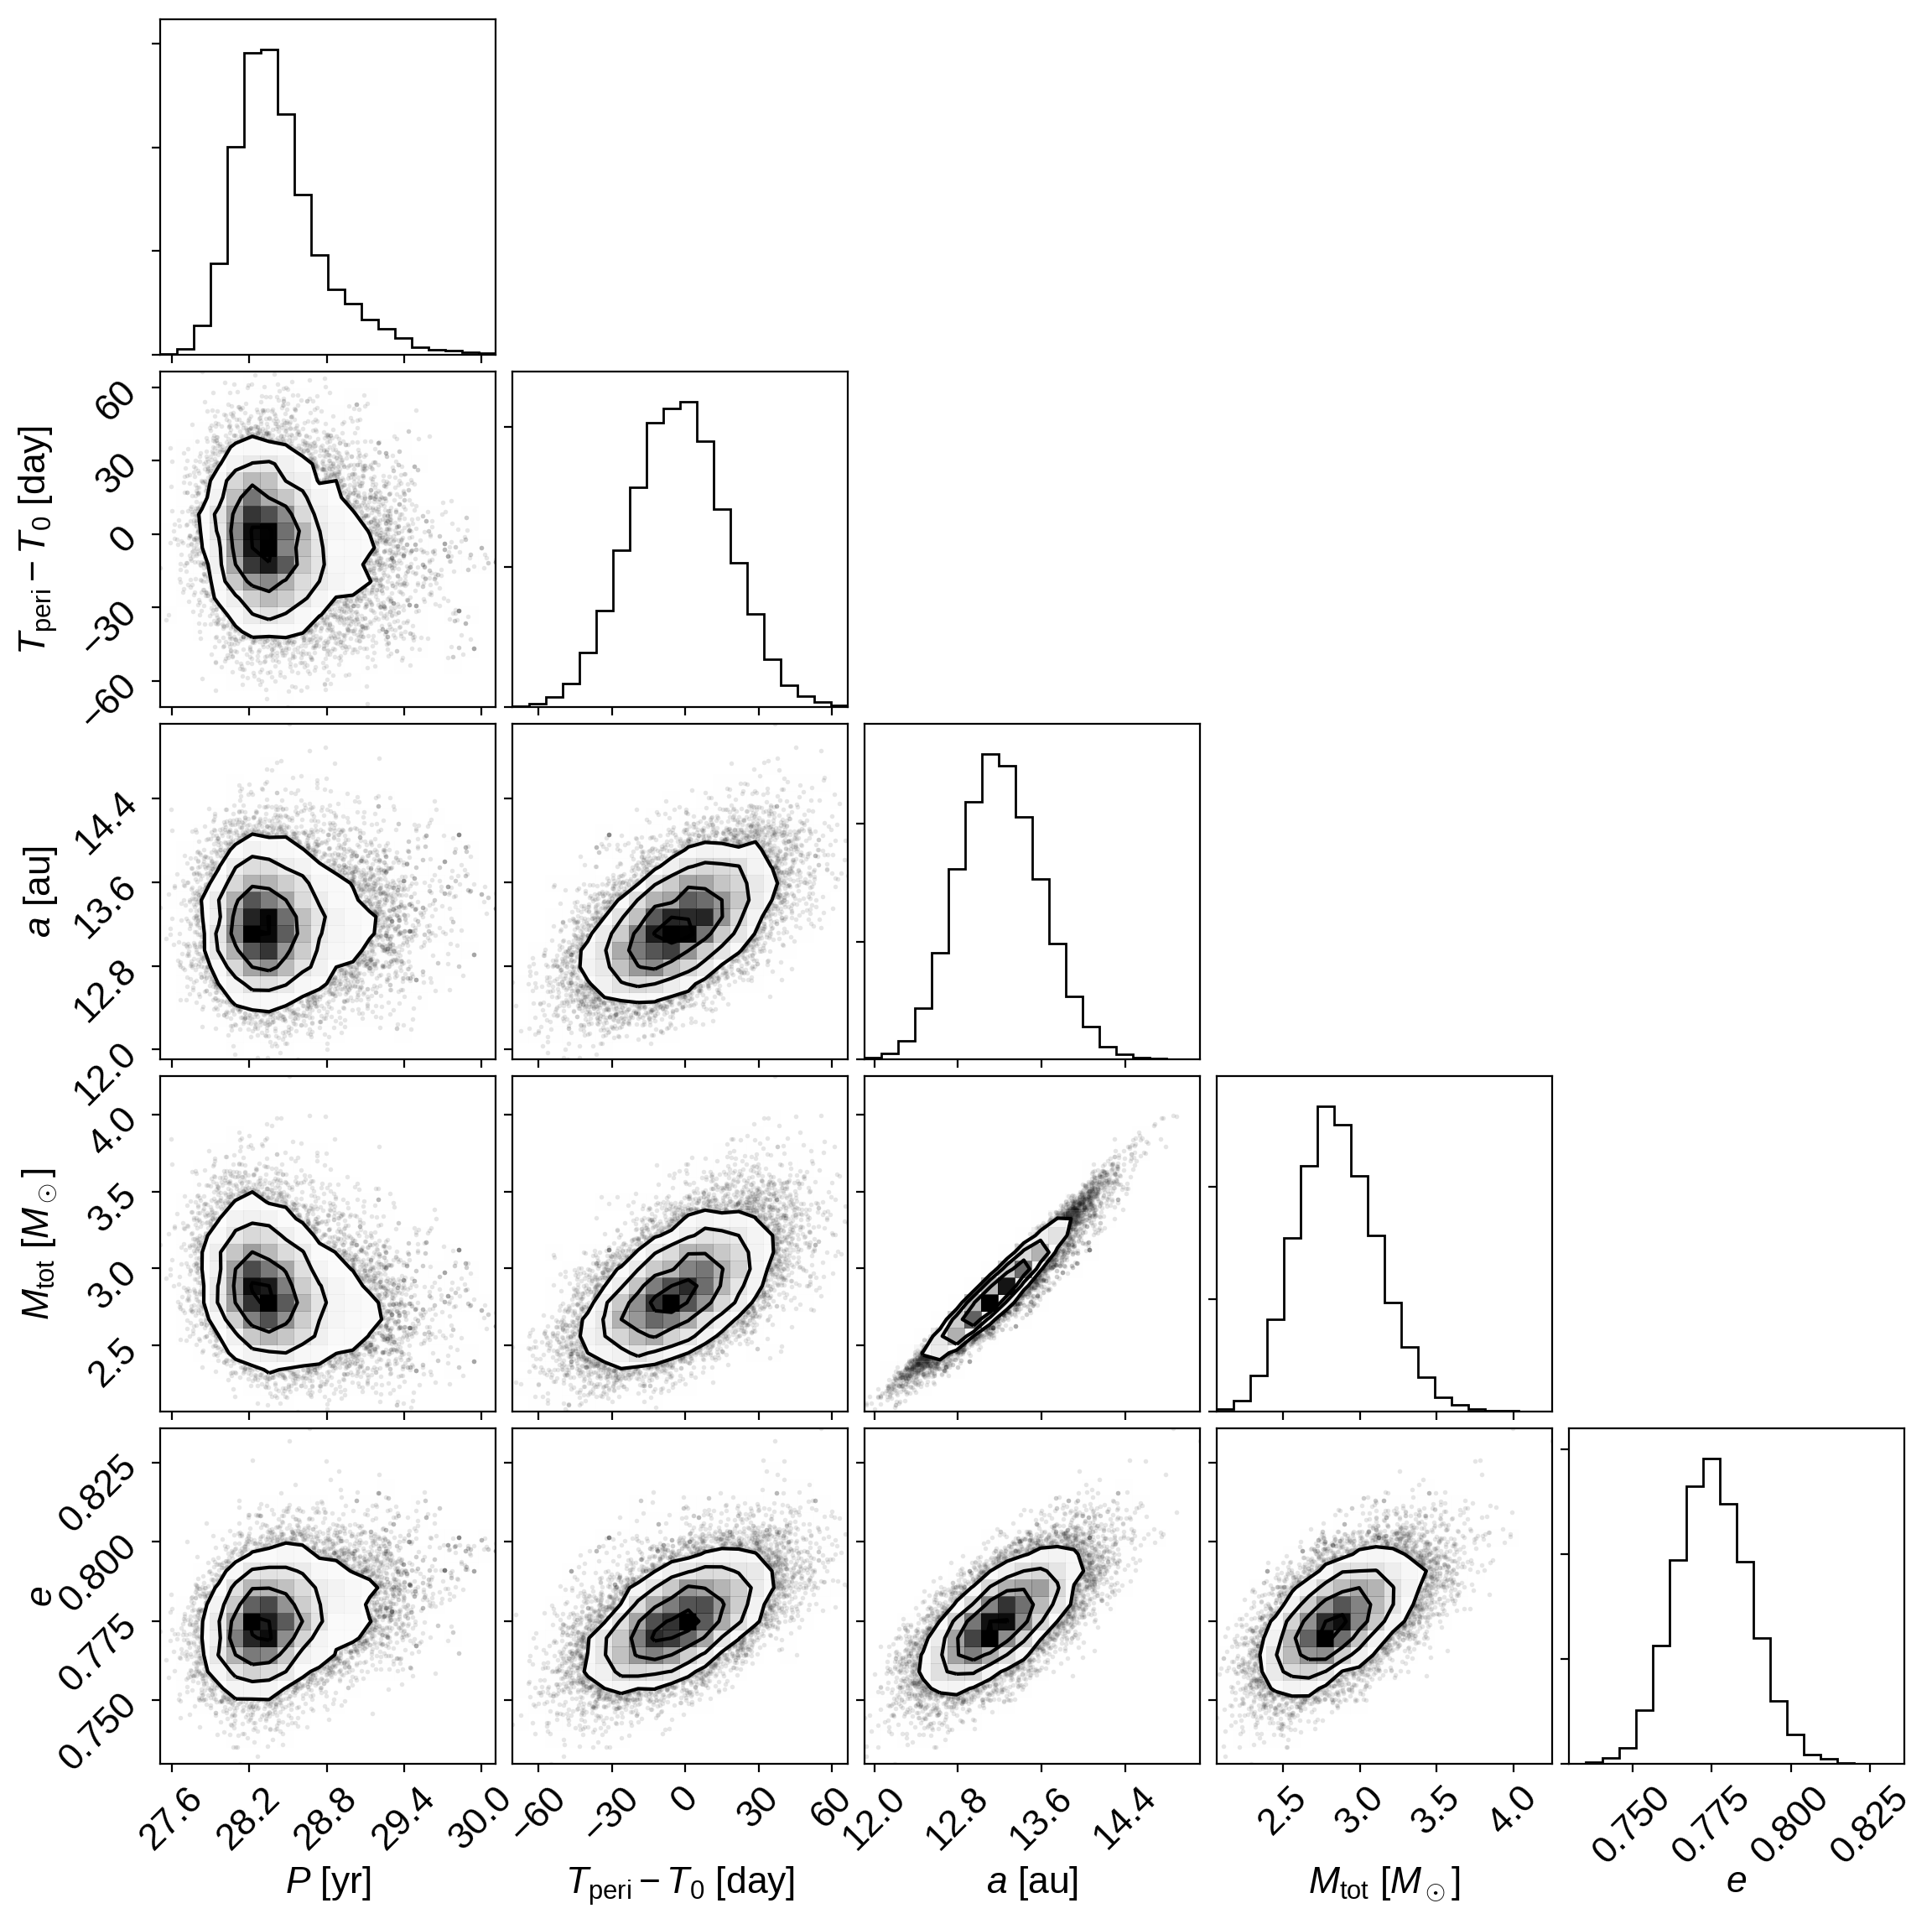

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
corner.corner(samples);

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.6},
   month = apr,
    year = 2019,
     doi = {10.5281/zenodo.2651251},
     url = {https://doi.org/10.5281/zenodo.2651251}
...
